<h1><center>  Deep Learning Project - Results </center></h1>

<p align="left">
<img src="https://upload.wikimedia.org/wikipedia/en/0/02/Stewie_Griffin.png" width="200"/>
    
_“In God we trust, all others bring data.”_ 

-W Edwards Deming

##### (Daniele Gammelli)

In [8]:
import argparse
import time
from os.path import exists

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import TransformedDistribution
# from pyro.distributions.transforms import InverseAutoregressiveFlow
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TracePredictive, EmpiricalMarginal, Predictive
from pyro.nn import AutoRegressiveNN
from pyro.optim import ClippedAdam
from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal

In [9]:
plt.style.use("ggplot")

### Utils

In [10]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.abs().mean())
            max_grads.append(p.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.show()

### Pyro Model 

In [207]:
class Emitter(nn.Module):
    """
    Parameterizes the bernoulli observation likelihood `p(x_t | z_t)`
    """

    def __init__(self, input_dim, z_dim, emission_dim):
        super(Emitter, self).__init__()
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_hidden_to_hidden = nn.Linear(emission_dim, emission_dim)
        self.lin_hidden_to_input_loc = nn.Linear(emission_dim, input_dim)
        # initialize the two non-linearities used in the neural network
        self.relu = nn.ReLU()

    def forward(self, z_t):
        """
        Given the latent z at a particular time step t we return the vector of
        probabilities `ps` that parameterizes the bernoulli distribution `p(x_t|z_t)`
        """
#         print("Emis_Zt, ", z_t.shape)
        h1 = self.relu(self.lin_z_to_hidden(z_t))
        h2 = self.relu(self.lin_hidden_to_hidden(h1))
        mu = self.lin_hidden_to_input_loc(h2)
#         print("Emis_MU, ", mu.shape)
        return mu


class GatedTransition(nn.Module):
    """
    Parameterizes the gaussian latent transition probability `p(z_t | z_{t-1})`
    See section 5 in the reference for comparison.
    """

    def __init__(self, z_dim, transition_dim):
        super(GatedTransition, self).__init__()
        # initialize the six linear transformations used in the neural network
        self.lin_gate_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)
        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the identity function
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)
        # initialize the three non-linearities used in the neural network
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        #self.batchnorm = nn.BatchNorm1d(num_features=transition_dim)

    def forward(self, z_t_1):
        """
        Given the latent `z_{t-1}` corresponding to the time step t-1
        we return the mean and scale vectors that parameterize the
        (diagonal) gaussian distribution `p(z_t | z_{t-1})`
        """
        # compute the gating function
        _gate = self.relu(self.lin_gate_z_to_hidden(z_t_1))
#         _gate = self.batchnorm(_gate)
        gate = torch.sigmoid(self.lin_gate_hidden_to_z(_gate))
        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(z_t_1))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)
        # assemble the actual mean used to sample z_t, which mixes a linear transformation
        # of z_{t-1} with the proposed mean modulated by the gating function
        loc = (1 - gate) * self.lin_z_to_loc(z_t_1) + gate * proposed_mean
        # compute the scale used to sample z_t, using the proposed mean from
        # above as input the softplus ensures that scale is positive
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))
        # return loc, scale which can be fed into Normal
        return loc, scale

class Combiner(nn.Module):
    """
    Parameterizes `q(z_t | z_{t-1}, x_{t:T})`, which is the basic building block
    of the guide (i.e. the variational distribution). The dependence on `x_{t:T}` is
    through the hidden state of the RNN (see the PyTorch module `rnn` below)
    """

    def __init__(self, z_dim, rnn_dim):
        super(Combiner, self).__init__()
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, rnn_dim)
        self.lin_hidden_to_loc = nn.Linear(rnn_dim, z_dim)
        self.lin_hidden_to_scale = nn.Linear(rnn_dim, z_dim)
        # initialize the two non-linearities used in the neural network
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1, h_rnn):
        """
        Given the latent z at at a particular time step t-1 as well as the hidden
        state of the RNN `h(x_{t:T})` we return the mean and scale vectors that
        parameterize the (diagonal) gaussian distribution `q(z_t | z_{t-1}, x_{t:T})`
        """
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.lin_z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state to compute the mean used to sample z_t
        loc = self.lin_hidden_to_loc(h_combined)
        # use the combined hidden state to compute the scale used to sample z_t
        scale = self.softplus(self.lin_hidden_to_scale(h_combined))
        # return loc, scale which can be fed into Normal
        return loc, scale
    
class DKF(nn.Module):
    """
    This PyTorch Module encapsulates the model as well as the
    variational distribution (the guide) for the Deep Markov Model
    """

    def __init__(self, input_dim=1, z_dim=10, emission_dim=30,
                 transition_dim=30, rnn_dim=10, num_layers=1, use_cuda=False, annealing_factor=1.):
        super(DKF, self).__init__()
        # instantiate PyTorch modules used in the model and guide below
        self.emitter = Emitter(input_dim, z_dim, emission_dim)
        self.trans = GatedTransition(z_dim, transition_dim)
        self.combiner = Combiner(z_dim, rnn_dim)
        # TODO manually define pytorch module
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=rnn_dim, nonlinearity="relu",
                         batch_first=True, bidirectional=False, num_layers=num_layers)
        # define a (trainable) parameters z_0 and z_q_0 that help define the probability
        # distributions p(z_1) and q(z_1)
        # (since for t = 1 there are no previous latents to condition on)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.sigma = nn.Parameter(torch.ones(input_dim)*0.3)
        # define a (trainable) parameter for the initial hidden state of the rnn
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))
        
        self.use_cuda = use_cuda
        self.annealing_factor = annealing_factor
        # if on gpu cuda-ize all PyTorch (sub)modules
        if use_cuda:
            self.cuda()

    # the model p(x_{1:T} | z_{1:T}) p(z_{1:T})
    def model(self, sequence=None):
        # get batch_size
        batch_size = len(sequence)
#         print("batch_size", batch_size)
        # this is the number of time steps we need to process in the mini-batch
        T_max = len(sequence[0]) if isinstance(sequence, list) else sequence.size(1)
        
        # register all PyTorch (sub)modules with pyro
        # this needs to happen in both the model and guide
        pyro.module("dkf", self)

        # set z_prev = z_0 to setup the recursive conditioning in p(z_t | z_{t-1})
        z_prev = self.z_0.expand(batch_size, self.z_0.size(0))
#         print("z_prev ", z_prev.shape)
        # we enclose all the sample statements in the model in a plate.
        # this marks that each datapoint is conditionally independent of the others
        with pyro.plate("data", batch_size):
            mus = torch.zeros((batch_size, T_max, 1))
            sigmas = torch.zeros((batch_size, T_max, 1))
            # sample the latents z and observed x's one time step at a time
            for t in range(1, T_max + 1):
                # the next chunk of code samples z_t ~ p(z_t | z_{t-1})
                # note that (both here and elsewhere) we use poutine.scale to take care
                # of KL annealing. we use the mask() method to deal with raggedness
                # in the observed data (i.e. different sequences in the mini-batch
                # have different lengths)

                # first compute the parameters of the diagonal gaussian distribution p(z_t | z_{t-1})
                z_loc, z_scale = self.trans(z_prev)
                
                # then sample z_t according to dist.Normal(z_loc, z_scale)
                # note that we use the reshape method so that the univariate Normal distribution
                # is treated as a multivariate Normal distribution with a diagonal covariance.
                with poutine.scale(scale=self.annealing_factor):
                    z_t = pyro.sample("z_%d" % t, dist.Normal(z_loc, z_scale).to_event(1))
#                 print("z_t, ", z_t.shape)
                # compute the probabilities that parameterize the bernoulli likelihood
                emission_mu_t = self.emitter(z_t)
#                 print("Mus, ", mus[:, t-1].shape)
#                 print("Emis, ", emission_mu_t.shape)
                mus[:,t-1,:] = emission_mu_t
                # the next statement instructs pyro to observe x_t according to the
                # bernoulli distribution p(x_t|z_t)
                if isinstance(sequence, list):
                    pyro.sample("obs_y_%d" % t,
                            dist.Normal(loc=emission_mu_t, scale=self.sigma).to_event(1), obs=None)
                else:
                    pyro.sample("obs_y_%d" % t, 
                                dist.Normal(loc=emission_mu_t, scale=self.sigma).to_event(1), obs=sequence[:, t-1, :].view(-1))
                # the latent sampled at this time step will be conditioned upon
                # in the next time step so keep track of it
                z_prev = z_t
            return mus
    
    def guide(self, sequence=None):
        # get batch_size
        batch_size = len(sequence)
        # this is the number of time steps we need to process in the mini-batch
        T_max = len(sequence[0]) if isinstance(sequence, list) else sequence.size(1)
        # register all PyTorch (sub)modules with pyro
        pyro.module("dkf", self)
        # if on gpu we need the fully broadcast view of the rnn initial state
        # to be in contiguous gpu memory
        h_0_contig = self.h_0.expand(1, batch_size, self.rnn.hidden_size).contiguous()
        # push the observed x's through the rnn;
        # rnn_output contains the hidden state at each time step
        rnn_output, rnn_hidden_state = self.rnn(sequence, h_0_contig)
        
        # reverse rnn_output to get initial ordering
#         rnn_output = torch.flip(rnn_output[:, :, :], dims=[1])
    
        # set z_prev = z_q_0 to setup the recursive conditioning in q(z_t |...)
        z_prev = self.z_q_0.expand(batch_size, self.z_q_0.size(0))
        
        # we enclose all the sample statements in the guide in a plate.
        # this marks that each datapoint is conditionally independent of the others.
        with pyro.plate("data", batch_size):
            # sample the latents z one time step at a time
            for t in range(1, T_max + 1):
                # the next two lines assemble the distribution q(z_t | z_{t-1}, x_{t:T})
                z_loc, z_scale = self.combiner(z_prev, rnn_output[:, t - 1, :])
                
                z_dist = dist.Normal(z_loc, z_scale)
                assert z_dist.event_shape == ()
                assert z_dist.batch_shape == (batch_size, self.z_q_0.size(0))
                # sample z_t from the distribution z_dist
                with pyro.poutine.scale(scale=self.annealing_factor):
                # ".to_event(1)" indicates latent dimensions are independent
                    z_t = pyro.sample("z_%d" % t, z_dist.to_event(1))
                # the latent sampled at this time step will be conditioned upon in the next time step
                # so keep track of it
                z_prev = z_t

In this Notebook we aim to compare Deep Kalman Filters with a set of baseline models as described in Section 3.2:

-----------------

# Table of Contents

1. [Data](#data)

    
2. [Autoregressive](#ar2)


3. [ARIMA](#arima)
        
    
4. [LSTM](#lstm)
    

5. [Vanilla - Deep Kalman Filters](#vdkf)


6. [Structured - Deep Kalman Filters](#sdkf)

-----------------

<a id="data"></a>

# Data

In [12]:
# Load data from 3 super-hubs
y_3 = np.load("/mnt/array/daga_data/Donkey_Demand_Prediction/GP Regression/Multiple-Time Series/Saved_elements/Inputs/y.npy")

In [163]:
# Split data between train and test 
T = 264 # train data
T_pred = y_3.shape[0] - T # prediction horizon
T_val = T_test = T_pred//2

In [164]:
y = y_3[:,0].reshape(-1,1)
y_train = y[:T].reshape(-1,1)
y_val = y[T:T+T_val].reshape(-1,1)
y_test = y[T+T_val:T+T_val+T_test].reshape(-1,1)

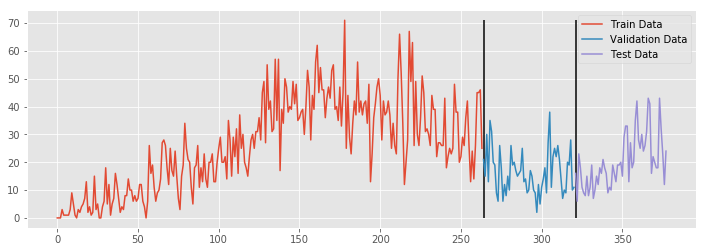

In [165]:
plt.figure(figsize=(12,4))
plt.plot(np.arange(T), y_train, label="Train Data")
plt.vlines(T, ymin=y.min(),ymax=y.max())
plt.vlines(T+T_val, ymin=y.min(),ymax=y.max())
plt.plot(np.arange(T, T + T_val), y_val, label="Validation Data")
plt.plot(np.arange(T + T_val, T + T_val + T_test), y_test, label="Test Data")
plt.legend()
plt.show()

In [166]:
# Standardize data
scaler = StandardScaler()
y_train_sc = scaler.fit_transform(y_train.reshape(-1,1))
y_val_sc = scaler.transform(y_val.reshape(-1,1))
y_test_sc = scaler.transform(y_test.reshape(-1,1))
y_sc = scaler.transform(y.reshape(-1,1))

# Transform to torch.tensor and reshape
y_train_sc = torch.from_numpy(y_train_sc).reshape(1, T, y_train_sc.shape[1])
y_val_sc = torch.from_numpy(y_val_sc).reshape(1, T_val, y_test_sc.shape[1])
y_test_sc = torch.from_numpy(y_test_sc).reshape(1, T_test, y_test_sc.shape[1])
y_sc = torch.from_numpy(y_sc).reshape(1, y_sc.shape[0], y_sc.shape[1])
y_train = torch.from_numpy(y_train).reshape(1, T, y_train.shape[1])
y_val = torch.from_numpy(y_val).reshape(1, T_val, y_val.shape[1])
y_test = torch.from_numpy(y_test).reshape(1, T_test, y_test.shape[1])
y = torch.from_numpy(y).reshape(1, y.shape[0], y.shape[1])

-----------

<a id="ar2"></a>

# AR(2) Model 

In [17]:
class AR2(nn.Module):
    def __init__(self):
        super(AR2, self).__init__()
        # define trainable parameters
        self.alpha = nn.Parameter(torch.tensor(1.))
        self.beta1 = nn.Parameter(torch.tensor(1.))
        self.beta2 = nn.Parameter(torch.tensor(1.))
        self.sigma = nn.Parameter(torch.tensor(1.))
        
    def forward(self, x_t_2, x_t_1):
        x_t = self.alpha + self.beta1*x_t_1 + self.beta2*x_t_2
        return x_t

In [18]:
# initialize model
ar2 = AR2()

In [19]:
# initialize optimizer + loss fn
optimizer = torch.optim.Adam(ar2.parameters(), lr=0.001)
likelihood = torch.distributions.Normal

Epoch: 1, NLL: 2.203, Val NLL: 1.309, alpha: 0.999, beta1: 0.999, beta2: 0.999
Epoch: 50, NLL: 2.008, Val NLL: 1.304, alpha: 0.951, beta1: 0.951, beta2: 0.951
Epoch: 100, NLL: 1.865, Val NLL: 1.302, alpha: 0.905, beta1: 0.906, beta2: 0.906
Epoch: 150, NLL: 1.761, Val NLL: 1.301, alpha: 0.861, beta1: 0.864, beta2: 0.864
Epoch: 200, NLL: 1.680, Val NLL: 1.300, alpha: 0.819, beta1: 0.825, beta2: 0.825
Epoch: 250, NLL: 1.614, Val NLL: 1.296, alpha: 0.779, beta1: 0.789, beta2: 0.788
Epoch: 300, NLL: 1.558, Val NLL: 1.290, alpha: 0.739, beta1: 0.754, beta2: 0.753
Epoch: 350, NLL: 1.509, Val NLL: 1.281, alpha: 0.701, beta1: 0.721, beta2: 0.720
Epoch: 400, NLL: 1.464, Val NLL: 1.268, alpha: 0.662, beta1: 0.690, beta2: 0.688
Epoch: 450, NLL: 1.421, Val NLL: 1.253, alpha: 0.624, beta1: 0.660, beta2: 0.657
Epoch: 500, NLL: 1.379, Val NLL: 1.234, alpha: 0.586, beta1: 0.631, beta2: 0.627
Epoch: 550, NLL: 1.337, Val NLL: 1.212, alpha: 0.548, beta1: 0.604, beta2: 0.599
Epoch: 600, NLL: 1.295, Val NLL

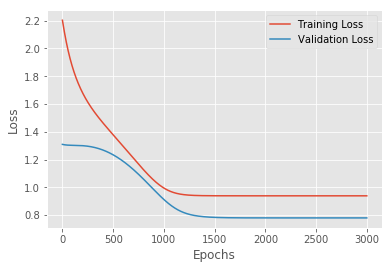

In [20]:
num_epochs = 3000
losses = []
val_losses = []
# train loop
for epoch in range(num_epochs):
    # run model forward
    output = ar2(y_train_sc.view(-1)[:T-2], y_train_sc.view(-1)[1:T-1])
    # compute loss and take gradient step
    nll = - likelihood(loc=output, scale=ar2.sigma).log_prob(y_train_sc.view(-1)[2:T]).sum()
    nll.backward()
    optimizer.step()
    optimizer.zero_grad()
    # book-keeping
    losses.append(nll/y_train_sc.view(-1)[2:T].size(0))
    
    # validation
    # run model forward
    output = ar2(y_val_sc.view(-1)[:-2], y_val_sc.view(-1)[1:-1])
    # compute loss and take gradient step
    nll_val = - likelihood(loc=output, scale=ar2.sigma).log_prob(y_val_sc.view(-1)[2:]).sum()
    # book-keeping
    val_losses.append(nll_val/y_val_sc.view(-1)[2:].size(0))
    if epoch % 50 == 49 or epoch == 0:
        print("Epoch: {0}, NLL: {1:.3f}, Val NLL: {2:.3f}, alpha: {3:.3f}, beta1: {4:.3f}, beta2: {5:.3f}".format(epoch+1, losses[-1], val_losses[-1],
                                                                                                ar2.alpha.item(), ar2.beta1.item(),
                                                                                               ar2.beta2.item()))

# Plot loss during training
plt.plot(np.arange(len(losses)), losses, label="Training Loss")
plt.plot(np.arange(len(losses)), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


==== TRAINING SET ====
R2: 0.613
MAE: 7.587
RMSE: 10.055

==== TEST SET ====
R2: 0.106
MAE: 6.574
RMSE: 8.303


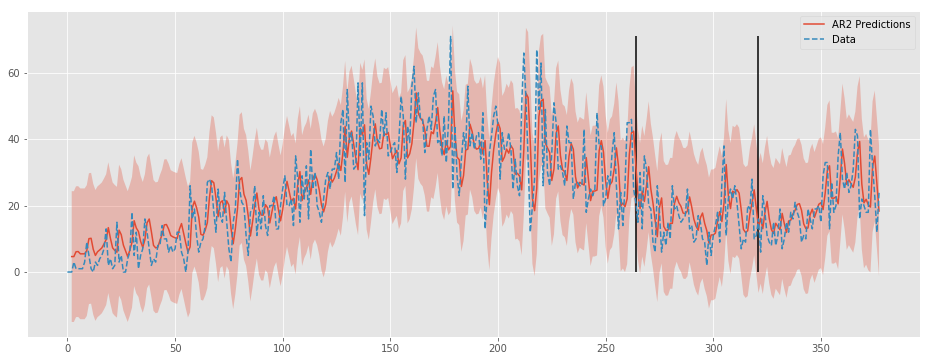

In [21]:
# compute predictions
y_pred_sc = ar2(x_t_2=y_sc.view(-1)[:-2], x_t_1=y_sc.view(-1)[1:-1]).detach().numpy()
y_pred = scaler.inverse_transform(y_pred_sc)
y_025 = scaler.inverse_transform(y_pred_sc - 1.96*ar2.sigma.detach().numpy())
y_975 = scaler.inverse_transform(y_pred_sc + 1.96*ar2.sigma.detach().numpy())
# evaluate performance metrics (on re-scaled data)
print("\n==== TRAINING SET ====")
print("R2: {0:.3f}".format(r2_score(y[0, 2:T], y_pred[:T-2])))
print("MAE: {0:.3f}".format(mean_absolute_error(y[0, 2:T], y_pred[:T-2])))
print("RMSE: {0:.3f}".format(np.sqrt(mean_squared_error(y[0, 2:T], y_pred[:T-2]))))
print("\n==== TEST SET ====")
print("R2: {0:.3f}".format(r2_score(y[0, T:], y_pred[T-2:])))
print("MAE: {0:.3f}".format(mean_absolute_error(y[0, T:], y_pred[T-2:])))
print("RMSE: {0:.3f}".format(np.sqrt(mean_squared_error(y[0, T:], y_pred[T-2:]))))

plt.figure(figsize=(16,6))
plt.plot(np.arange(2, T+T_pred), y_pred, label="AR2 Predictions")
plt.fill_between(np.arange(2, T+T_pred), y_025, y_975, alpha=0.3)
plt.plot(np.arange(T + T_pred), y[0,:], label="Data", linestyle="--")
plt.vlines(T, ymin=y[0,:].min(),ymax=y[0,:].max())
plt.vlines(T+T_val, ymin=y[0,:].min(),ymax=y[0,:].max())
plt.legend()
plt.show()

----------

<a id="arima"></a>

# ARIMA

In [22]:
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd

In [23]:
# Genrate pd.Series of the training data as input to ARIMA model
y_train_df = pd.Series(y_train_sc.view(-1).numpy())
y_val_df = pd.Series(y_val_sc.view(-1).numpy())
y_test_df = pd.Series(y_test_sc.view(-1).numpy())
y_df = pd.Series(y_sc.view(-1).numpy())

train_idx = np.arange(T-7)
val_idx = np.arange(T-7, T+T_val-7)
test_idx = np.arange(T+T_val-7, T+T_pred-7)

In [24]:
arima = ARIMA(endog=y_train_df, order=(5, 1, 0))

In [25]:
arima_fit = arima.fit(disp=0)

In [26]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -215.834
Method:                       css-mle   S.D. of innovations              0.548
Date:                Fri, 03 Jan 2020   AIC                            445.667
Time:                        21:03:27   BIC                            470.672
Sample:                             1   HQIC                           455.716
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0077      0.010      0.756      0.450      -0.012       0.028
ar.L1.D.y     -0.6594      0.058    -11.337      0.000      -0.773      -0.545
ar.L2.D.y     -0.3552      0.063     -5.609      0.000      -0.479      -0.231
ar.L3.D.y     -0.4646      0.061     -7.664      0.000      -0.583      -0.346
ar.L4.D.y     -0.5339      0.064     -8.400      0.000      -0.658      -0.409
ar.L5.D.y     -0.3295      0.058     -5.635      0.000      -0.444      -0.215
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6476           -0.9355j            1.1378           -0.1536
AR.2            0.6476           +0.9355j            1.1378            0.1536
AR.3           -1.3110           -0.0000j            1.3110           -0.5000
AR.4           -0.8021           -1.0699j            1.3372           -0.3524
AR.5           -0.8021           +1.0699j            1.3372            0.3524
-----------------------------------------------------------------------------
"""

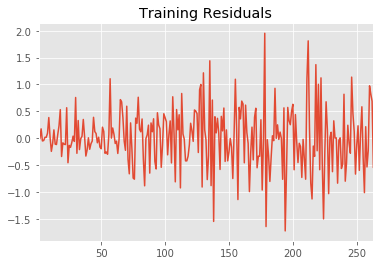

In [27]:
# Plot residuals
residuals = pd.DataFrame(arima_fit.resid)
residuals.plot(legend=False)
plt.title("Training Residuals");

In [28]:
history = [x for x in pd.concat([y_train_df, y_val_df])]
predictions = list()
predictions_025 = list()
predictions_975 = list()
for t in range(len(y_test_df)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    predictions_025.append(output[2][0][0])
    predictions_975.append(output[2][0][1])
    obs = y_test_df[t]
    history.append(obs)

In [29]:
y_pred_arima_sc = predictions
y_025_arima_sc = predictions_025
y_975_arima_sc = predictions_975

y_pred_arima = scaler.inverse_transform(predictions)
y_025_arima = scaler.inverse_transform(predictions_025)
y_975_arima = scaler.inverse_transform(predictions_975)


==== TEST SET ====
R2: 0.306
MAE: 5.907
RMSE: 7.502


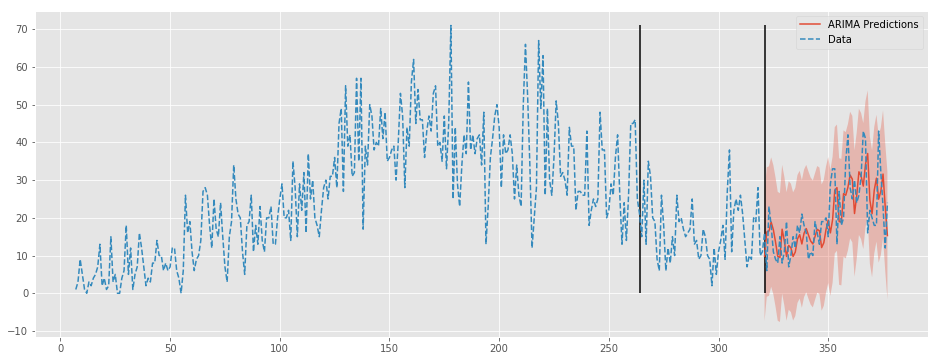

In [30]:
# evaluate performance metrics
print("\n==== TEST SET ====")
print("R2: {0:.3f}".format(r2_score(y[:, test_idx, :].view(-1), y_pred_arima)))
print("MAE: {0:.3f}".format(mean_absolute_error(y[:, test_idx, :].view(-1), y_pred_arima)))
print("RMSE: {0:.3f}".format(np.sqrt(mean_squared_error(y[:, test_idx, :].view(-1), y_pred_arima))))

plt.figure(figsize=(16,6))
plt.plot(np.arange(T+T_val, T+T_pred), y_pred_arima, label="ARIMA Predictions")
plt.fill_between(np.arange(T+T_val, T+T_pred), y_025_arima, 
                 y_975_arima, alpha=0.3)
plt.plot(np.arange(7, T + T_pred), y[:, 7:, :].detach().numpy().flatten(), label="Data", linestyle="--")
plt.vlines(T, ymin=y[0,:].min(),ymax=y[0,:].max())
plt.vlines(T+T_val, ymin=y[0,:].min(),ymax=y[0,:].max())
plt.legend()
plt.show()

-----------

<a id="lstm"></a>

# LSTM 

In [170]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=30, num_layers=1,
                           batch_first=True, dropout=0., bidirectional=False)
        self.sigma = nn.Parameter(torch.tensor(1.)*0.1)
        
        # Output layer
        self.l_out = nn.Linear(in_features=self.lstm.hidden_size*7,
                            out_features=1,
                            bias=True)
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x_t = self.l_out(x.reshape(x.shape[0], -1))
        return x_t, (h, c)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [171]:
data_list_sc = create_inout_sequences(y_sc.view(-1), 7)
data_list = create_inout_sequences(y.view(-1), 7)

In [172]:
X = torch.zeros(len(data_list), 7, 1)
y = torch.zeros(len(data_list))

In [173]:
X_sc = torch.zeros(len(data_list_sc), 7, 1)
y_sc = torch.zeros(len(data_list_sc))

In [174]:
for i, elem in enumerate(data_list):
    X[i, :, 0] = elem[0]
    y[i] = elem[1]

for i, elem in enumerate(data_list_sc):
    X_sc[i, :, 0] = elem[0]
    y_sc[i] = elem[1]

In [175]:
train_idx = np.arange(T-7)
val_idx = np.arange(T-7, T+T_val-7)
test_idx = np.arange(T+T_val-7, T+T_pred-7)

In [176]:
X_train = X[train_idx, :, :]
X_val = X[val_idx, :, :]
X_test = X[test_idx, :, :]
y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]

X_train_sc = X_sc[train_idx, :, :]
X_val_sc = X_sc[val_idx, :, :]
X_test_sc = X_sc[test_idx, :, :]
y_train_sc = y_sc[train_idx]
y_val_sc = y_sc[val_idx]
y_test_sc = y_sc[test_idx]

In [177]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([257, 7, 1]),
 torch.Size([57, 7, 1]),
 torch.Size([57, 7, 1]),
 torch.Size([257]),
 torch.Size([57]),
 torch.Size([57]))

In [193]:
# initialize model
lstm = LSTM()

In [194]:
# initialize optimizer + loss fn
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
likelihood = torch.distributions.Normal

Epoch: 1, NLL Train: 44.861, NLL Valid: 24.856, sigma: 0.101
Epoch: 100, NLL Train: 6.158, NLL Valid: 6.040, sigma: 0.152
Epoch: 200, NLL Train: 4.089, NLL Valid: 4.187, sigma: 0.179
Epoch: 300, NLL Train: 2.998, NLL Valid: 3.264, sigma: 0.201
Epoch: 400, NLL Train: 2.362, NLL Valid: 2.668, sigma: 0.218
Epoch: 500, NLL Train: 1.998, NLL Valid: 2.217, sigma: 0.233
Epoch: 600, NLL Train: 1.756, NLL Valid: 1.937, sigma: 0.246
Epoch: 700, NLL Train: 1.573, NLL Valid: 1.753, sigma: 0.258
Epoch: 800, NLL Train: 1.419, NLL Valid: 1.625, sigma: 0.269
Epoch: 900, NLL Train: 1.278, NLL Valid: 1.564, sigma: 0.279
Epoch: 1000, NLL Train: 1.134, NLL Valid: 1.492, sigma: 0.288
Epoch: 1100, NLL Train: 1.015, NLL Valid: 1.432, sigma: 0.296
Epoch: 1200, NLL Train: 0.928, NLL Valid: 1.386, sigma: 0.303
Epoch: 1300, NLL Train: 0.856, NLL Valid: 1.344, sigma: 0.310


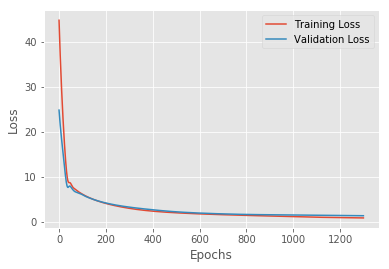

In [195]:
torch.manual_seed(10)
num_epochs = 1300
losses = []
val_losses = []
val_loss_best = np.inf
# train loop
for epoch in range(num_epochs):
    try:
        # run model forward
        output, (h, c) = lstm(X_train_sc.float())
        # compute loss and take gradient step
        nll = - likelihood(loc=output, scale=lstm.sigma).log_prob(y_train_sc.reshape(-1,1)).sum()
        nll.backward()
        optimizer.step()
        optimizer.zero_grad()
        # book-keeping
        losses.append(nll/y_train_sc.size(0))
        
        # Early Stopping
        output, (h, c) = lstm(X_val_sc.float())
        val_loss = - likelihood(loc=output, scale=lstm.sigma).log_prob(y_val_sc.reshape(-1,1)).sum()
        val_losses.append(val_loss/y_val_sc.size(0))
        if epoch % 100 == 99 or epoch == 0:
            output, (h, c) = lstm(X_val_sc.float())
            val_loss = - likelihood(loc=output, scale=lstm.sigma).log_prob(y_val_sc.reshape(-1,1)).sum()
            print("Epoch: {0}, NLL Train: {1:.3f}, NLL Valid: {2:.3f}, sigma: {3:.3f}".format(epoch+1, losses[-1], val_losses[-1], lstm.sigma.item()))

    
    except KeyboardInterrupt:
        plt.plot(np.arange(len(losses)), losses)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()
        plt.plot(np.arange(len(val_losses)), val_losses)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()
        break

# Plot loss during training
plt.plot(np.arange(len(losses)), losses, label="Training Loss")
plt.plot(np.arange(len(losses)), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();


==== TRAINING SET ====
R2: 0.778
MAE: 5.678
RMSE: 7.499

==== TEST SET ====
R2: 0.393
MAE: 5.840
RMSE: 7.271


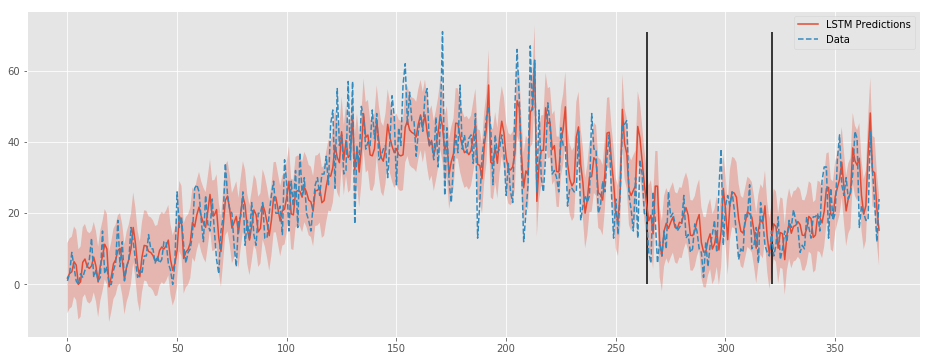

In [196]:
# compute predictions
y_pred_sc, (h, c) = lstm(X_sc.float())
y_pred_sc = y_pred_sc.detach().numpy().reshape(-1,)
y_pred = scaler.inverse_transform(y_pred_sc)
y_025 = scaler.inverse_transform(y_pred_sc - 1.96*lstm.sigma.detach().numpy())
y_975 = scaler.inverse_transform(y_pred_sc + 1.96*lstm.sigma.detach().numpy())

# evaluate performance metrics (on re-scaled data)
print("\n==== TRAINING SET ====")
print("R2: {0:.3f}".format(r2_score(y[train_idx], y_pred[train_idx])))
print("MAE: {0:.3f}".format(mean_absolute_error(y[train_idx], y_pred[train_idx])))
print("RMSE: {0:.3f}".format(np.sqrt(mean_squared_error(y[train_idx], y_pred[train_idx]))))
print("\n==== TEST SET ====")
print("R2: {0:.3f}".format(r2_score(y[test_idx], y_pred[test_idx])))
print("MAE: {0:.3f}".format(mean_absolute_error(y_test, y_pred[test_idx])))
print("RMSE: {0:.3f}".format(np.sqrt(mean_squared_error(y_test, y_pred[test_idx]))))

plt.figure(figsize=(16,6))
plt.plot(y_pred, label="LSTM Predictions")
plt.fill_between(np.arange(T+T_pred-7), y_025, 
                 y_975, alpha=0.3)
plt.plot(y, label="Data", linestyle="--")
plt.vlines(T, ymin=y.min(),ymax=y.max())
plt.vlines(T+T_val, ymin=y.min(),ymax=y.max())
plt.legend()
plt.show()

----------

<a id="vdkf"></a>

# Vanilla - Deep Kalman Filters

In [208]:
use_cuda = False
dkf = DKF(use_cuda=use_cuda, annealing_factor=0.01, input_dim=1, z_dim=50, rnn_dim=100, emission_dim=30, transition_dim=30)
guide = AutoDiagonalNormal(dkf.model)

In [209]:
svi = SVI(dkf.model, guide, optim=pyro.optim.ClippedAdam({"lr": .009, "clip_norm": 5.0, "lrd": 0.995}), loss=Trace_ELBO(num_particles=1))

In [210]:
if use_cuda:
    y_sc = y_sc.float().cuda()
    y_train_sc = y_train_sc.float().cuda()
    y_test_sc = y_test_sc.float().cuda()
y_sc = y_sc.float()
y_train_sc = y_train_sc.float()
y_test_sc = y_test_sc.float()

Epoch: 1, Loss: 46.994, Val Loss: 196.797, sigma: 1.399

==== Train Results ====
R2: 0.124, MAE: 12.518, RMSE: 15.216
==== Validation Results ====
R2: -2.322, MAE: 12.525, RMSE: 14.113
==== Test Results ====
R2: -0.668, MAE: 10.615, RMSE: 12.053


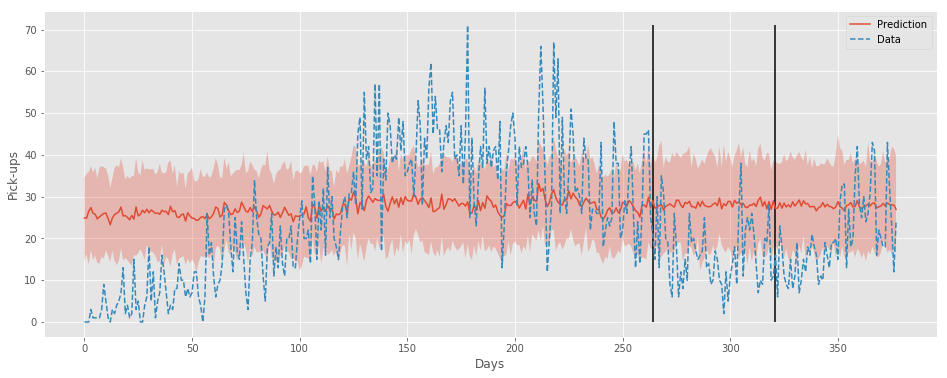

Epoch: 2, Loss: 46.375, Val Loss: 195.348, sigma: 1.411
Epoch: 3, Loss: 45.619, Val Loss: 191.596, sigma: 1.423
Epoch: 4, Loss: 44.248, Val Loss: 191.258, sigma: 1.436
Epoch: 5, Loss: 43.223, Val Loss: 188.917, sigma: 1.448
Epoch: 6, Loss: 42.582, Val Loss: 186.237, sigma: 1.461
Epoch: 7, Loss: 42.277, Val Loss: 184.877, sigma: 1.473
Epoch: 8, Loss: 40.633, Val Loss: 181.244, sigma: 1.486
Epoch: 9, Loss: 40.509, Val Loss: 182.183, sigma: 1.499
Epoch: 10, Loss: 39.278, Val Loss: 180.289, sigma: 1.511
Epoch: 11, Loss: 39.007, Val Loss: 178.843, sigma: 1.524
Epoch: 12, Loss: 38.621, Val Loss: 176.136, sigma: 1.537
Epoch: 13, Loss: 38.352, Val Loss: 176.780, sigma: 1.550
Epoch: 14, Loss: 37.541, Val Loss: 176.215, sigma: 1.560
Epoch: 15, Loss: 37.092, Val Loss: 174.017, sigma: 1.567
Epoch: 16, Loss: 37.373, Val Loss: 170.638, sigma: 1.572
Epoch: 17, Loss: 36.120, Val Loss: 166.564, sigma: 1.575
Epoch: 18, Loss: 35.800, Val Loss: 163.808, sigma: 1.577
Epoch: 19, Loss: 36.083, Val Loss: 163.

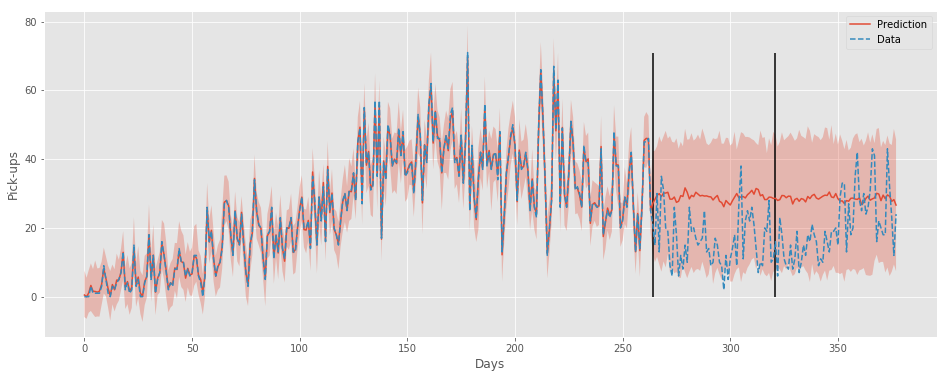

In [213]:
num_epochs = 500
losses = []
val_losses = []
r2_list = [[],[]]
mae_list = [[],[]]
mape_list = [[],[]]
rmse_list = [[],[]]
pyro.clear_param_store()
for epoch in range(num_epochs):
    try:
        dkf.train()
        loss = 0
        loss += svi.step(y_train_sc)/y_train_sc.size(1)
        losses.append(loss)
        val_loss = 0
        val_loss += svi.evaluate_loss(y_val_sc) / y_val_sc.size(1)
        print("Epoch: {0}, Loss: {1:.3f}, Val Loss: {2:.3f}, sigma: {3:.3f}".format(epoch+1, loss, val_loss, torch.exp(dkf.sigma).item()))
        val_losses.append(val_loss)
        
        
        if epoch % 500 == 499 or epoch == 0:
            dkf.eval()
            
            sites = ["obs_y_%d"%t for t in range(1,T + T_pred + 1)]
            predictive = Predictive(dkf.model, guide=guide, num_samples=100, return_sites=sites)
            samples = predictive([[None]*(T + T_pred)])
            
            y_samples = []
            y_mean = []
            y_025 = []
            y_975 = []
            for t in range(T + T_pred):
                y_t = samples["obs_y_%d"%(t+1)].reshape(-1,1).detach().numpy()
                y_samples.append(y_t)

                y_mean.append(np.mean(y_t, axis=0))
                y_025.append(np.quantile(a=y_t, q=0.025, axis=0))
                y_975.append(np.quantile(a=y_t, q=0.975, axis=0))

            # compute predictions
            y_pred = scaler.inverse_transform(np.array(y_mean).reshape(-1,1))
            y_025 = scaler.inverse_transform(np.array(y_025).reshape(-1,1))
            y_975 = scaler.inverse_transform(np.array(y_975).reshape(-1,1))

            r2_train = r2_score(y_train.reshape(-1,1), y_pred[:T])
            mae_train = mean_absolute_error(y_train.reshape(-1,1), y_pred[:T])
            rmse_train = np.sqrt(mean_squared_error(y_train.reshape(-1,1), y_pred[:T]))
            
            r2_val = r2_score(y_val.reshape(-1,1), y_pred[T:T+T_val])
            mae_val = mean_absolute_error(y_val.reshape(-1,1), y_pred[T:T+T_val])
            rmse_val = np.sqrt(mean_squared_error(y_val.reshape(-1,1), y_pred[T:T+T_val]))
            
            r2_test = r2_score(y_test.reshape(-1,1), y_pred[T+T_val:])
            mae_test = mean_absolute_error(y_test.reshape(-1,1), y_pred[T+T_val:])
            rmse_test = np.sqrt(mean_squared_error(y_test.reshape(-1,1), y_pred[T+T_val:]))
            print("\n==== Train Results ====")
            print("R2: {0:.3f}, MAE: {1:.3f}, RMSE: {2:.3f}".format(r2_train, mae_train, rmse_train))
            print("==== Validation Results ====")
            print("R2: {0:.3f}, MAE: {1:.3f}, RMSE: {2:.3f}".format(r2_val, mae_val, rmse_val))
            print("==== Test Results ====")
            print("R2: {0:.3f}, MAE: {1:.3f}, RMSE: {2:.3f}".format(r2_test, mae_test, rmse_test))
            
            for hub in range(y_sc.shape[2]):
                plt.figure(figsize=(16, 6))
                plt.plot(y_pred[:,hub], label="Prediction")
                plt.fill_between(np.arange(len(y_025[:,hub])), y_025[:,hub], y_975[:,hub], alpha=0.3)
                plt.vlines(T, ymin=y.min(),ymax=y.max())
                plt.vlines(T+T_val, ymin=y.min(),ymax=y.max())
                plt.plot(np.arange(T+T_pred), y, label="Data", linestyle="--")
                plt.xlabel("Days")
                plt.ylabel("Pick-ups")
                plt.legend()
                plt.show()
            
    except KeyboardInterrupt:
        plt.plot(np.arange(len(losses)), losses, label="Training Loss")
        plt.plot(np.arange(len(val_losses)), val_losses, label="Validation Loss")
        plt.legend()
        plt.show()
        break
if use_cuda:
    y = y.cpu()
    y_val = y_val.cpu()


==== Train Results ====
R2: 0.999, MAE: 0.487, RMSE: 0.617
==== Validation Results ====
R2: -2.707, MAE: 13.317, RMSE: 14.909
==== Test Results ====
R2: -1.027, MAE: 11.749, RMSE: 13.286


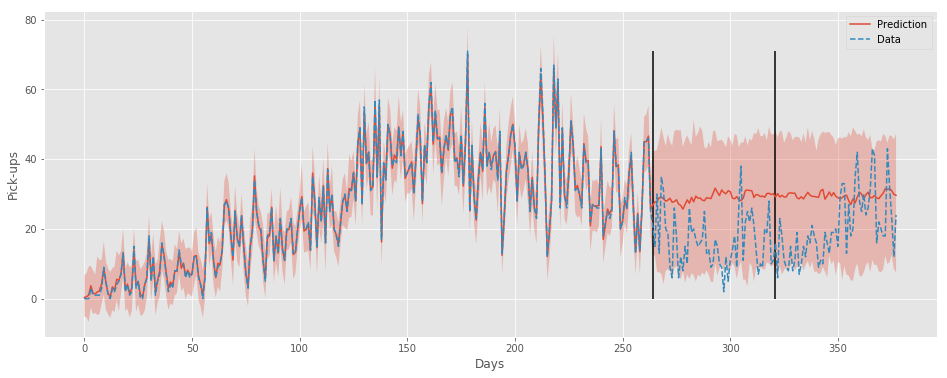

In [214]:
dkf.eval()
            
sites = ["obs_y_%d"%t for t in range(1,T + T_pred + 1)]
predictive = Predictive(dkf.model, guide=guide, num_samples=100, return_sites=sites)
samples = predictive([[None]*(T + T_pred)])

y_samples = []
y_mean = []
y_025 = []
y_975 = []
for t in range(T + T_pred):
    y_t = samples["obs_y_%d"%(t+1)].reshape(-1,1).detach().numpy()
    y_samples.append(y_t)

    y_mean.append(np.mean(y_t, axis=0))
    y_025.append(np.quantile(a=y_t, q=0.025, axis=0))
    y_975.append(np.quantile(a=y_t, q=0.975, axis=0))

# compute predictions
y_pred = scaler.inverse_transform(np.array(y_mean).reshape(-1,1))
y_025 = scaler.inverse_transform(np.array(y_025).reshape(-1,1))
y_975 = scaler.inverse_transform(np.array(y_975).reshape(-1,1))

r2_train = r2_score(y_train.reshape(-1,1), y_pred[:T])
mae_train = mean_absolute_error(y_train.reshape(-1,1), y_pred[:T])
rmse_train = np.sqrt(mean_squared_error(y_train.reshape(-1,1), y_pred[:T]))

r2_val = r2_score(y_val.reshape(-1,1), y_pred[T:T+T_val])
mae_val = mean_absolute_error(y_val.reshape(-1,1), y_pred[T:T+T_val])
rmse_val = np.sqrt(mean_squared_error(y_val.reshape(-1,1), y_pred[T:T+T_val]))

r2_test = r2_score(y_test.reshape(-1,1), y_pred[T+T_val:])
mae_test = mean_absolute_error(y_test.reshape(-1,1), y_pred[T+T_val:])
rmse_test = np.sqrt(mean_squared_error(y_test.reshape(-1,1), y_pred[T+T_val:]))
print("\n==== Train Results ====")
print("R2: {0:.3f}, MAE: {1:.3f}, RMSE: {2:.3f}".format(r2_train, mae_train, rmse_train))
print("==== Validation Results ====")
print("R2: {0:.3f}, MAE: {1:.3f}, RMSE: {2:.3f}".format(r2_val, mae_val, rmse_val))
print("==== Test Results ====")
print("R2: {0:.3f}, MAE: {1:.3f}, RMSE: {2:.3f}".format(r2_test, mae_test, rmse_test))

for hub in range(y_sc.shape[2]):
    plt.figure(figsize=(16, 6))
    plt.plot(y_pred[:,hub], label="Prediction")
    plt.fill_between(np.arange(len(y_025[:,hub])), y_025[:,hub], y_975[:,hub], alpha=0.3)
    plt.vlines(T, ymin=y.min(),ymax=y.max())
    plt.vlines(T+T_val, ymin=y.min(),ymax=y.max())
    plt.plot(np.arange(T+T_pred), y, label="Data", linestyle="--")
    plt.xlabel("Days")
    plt.ylabel("Pick-ups")
    plt.legend()
    plt.show()

-------

<a id="sdkf"></a>

# Structured - Deep Kalman Filters

In [198]:
y = y_3[:,0].reshape(-1,1)
y_train = y[:T].reshape(-1,1)
y_val = y[T:T+T_val].reshape(-1,1)
y_test = y[T+T_val:T+T_val+T_test].reshape(-1,1)

In [199]:
# Standardize data
scaler = StandardScaler()
y_train_sc = scaler.fit_transform(y_train.reshape(-1,y.shape[1]))
y_val_sc = scaler.transform(y_val.reshape(-1,y.shape[1]))
y_test_sc = scaler.transform(y_test.reshape(-1,y.shape[1]))
y_sc = scaler.transform(y.reshape(-1,y.shape[1]))

# Transform to torch.tensor and reshape
y_train_sc = torch.from_numpy(y_train_sc).reshape(1, T, y_train_sc.shape[1])
y_val_sc = torch.from_numpy(y_val_sc).reshape(1, T_val, y_val_sc.shape[1])
y_test_sc = torch.from_numpy(y_test_sc).reshape(1, T_test, y_test_sc.shape[1])
y_sc = torch.from_numpy(y_sc).reshape(1, y_sc.shape[0], y_sc.shape[1])

In [200]:
use_cuda = False
dkf = DKF(use_cuda=use_cuda, annealing_factor=0.01, input_dim=1, z_dim=50, rnn_dim=100, emission_dim=30, transition_dim=30)
svi = SVI(dkf.model, dkf.guide, optim=pyro.optim.Adam({"lr":0.001}), loss=Trace_ELBO(num_particles=1))

In [145]:
if use_cuda:
    y_sc = y_sc.float().cuda()
    y_train_sc = y_train_sc.float().cuda()
    y_val_sc = y_val_sc.float().cuda()
    y_test_sc = y_test_sc.float().cuda()
y_sc = y_sc.float()
y_train_sc = y_train_sc.float()
y_val_sc = y_val_sc.float()
y_test_sc = y_test_sc.float()

Epoch: 1, Loss: 5.523, Val Loss: 4.101, sigma: 0.301
Epoch: 2, Loss: 5.461, Val Loss: 4.094, sigma: 0.302
Epoch: 3, Loss: 5.380, Val Loss: 3.786, sigma: 0.303
Epoch: 4, Loss: 5.319, Val Loss: 3.735, sigma: 0.304
Epoch: 5, Loss: 5.289, Val Loss: 3.680, sigma: 0.305
Epoch: 6, Loss: 5.172, Val Loss: 3.544, sigma: 0.306
Epoch: 7, Loss: 5.143, Val Loss: 3.460, sigma: 0.307
Epoch: 8, Loss: 5.104, Val Loss: 3.296, sigma: 0.308
Epoch: 9, Loss: 5.030, Val Loss: 3.289, sigma: 0.309
Epoch: 10, Loss: 4.944, Val Loss: 3.268, sigma: 0.310
Epoch: 11, Loss: 4.988, Val Loss: 3.145, sigma: 0.311
Epoch: 12, Loss: 4.948, Val Loss: 3.110, sigma: 0.312
Epoch: 13, Loss: 4.848, Val Loss: 2.995, sigma: 0.313
Epoch: 14, Loss: 4.781, Val Loss: 2.797, sigma: 0.314
Epoch: 15, Loss: 4.705, Val Loss: 2.795, sigma: 0.315
Epoch: 16, Loss: 4.685, Val Loss: 2.795, sigma: 0.316
Epoch: 17, Loss: 4.582, Val Loss: 2.551, sigma: 0.317
Epoch: 18, Loss: 4.499, Val Loss: 2.232, sigma: 0.318
Epoch: 19, Loss: 4.377, Val Loss: 2.0

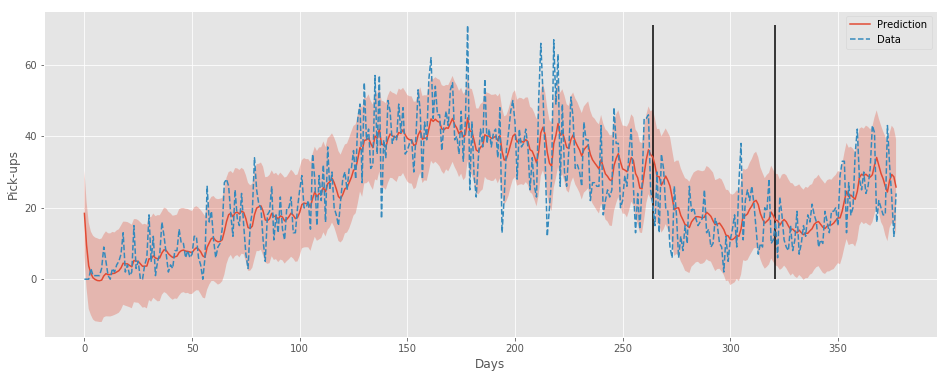

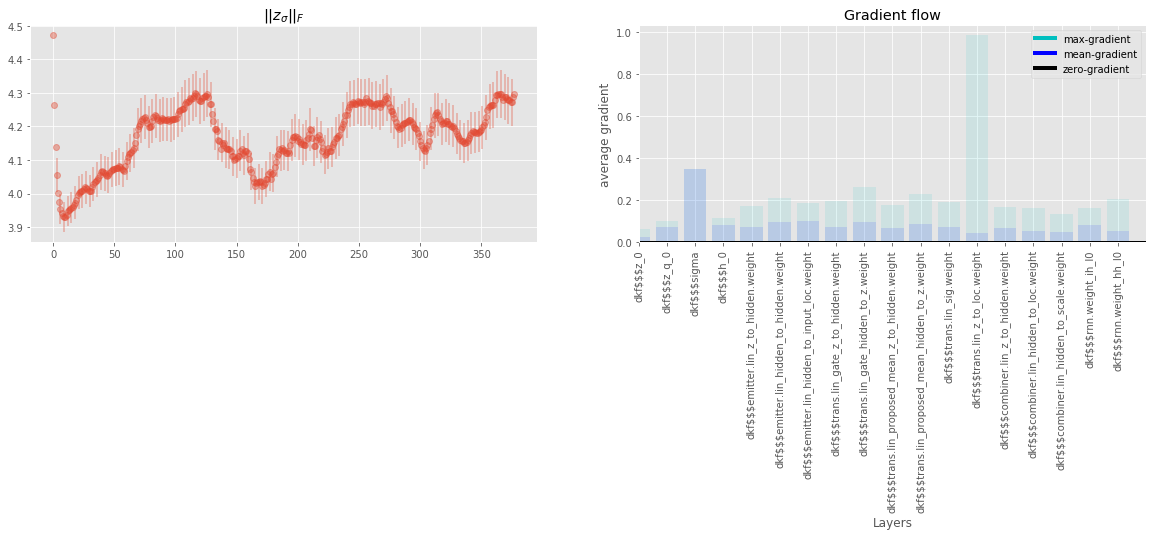

In [146]:
torch.manual_seed(10)
num_epochs = 90
losses = []
val_losses = []
pyro.clear_param_store()
for epoch in range(num_epochs):
    try:
        loss = 0
        loss += svi.step(y_train_sc)/y_train_sc.size(1)
        losses.append(loss)
        val_loss = 0
        val_loss += svi.evaluate_loss(y_val_sc) / y_val_sc.size(1)
        print("Epoch: {0}, Loss: {1:.3f}, Val Loss: {2:.3f}, sigma: {3:.3f}".format(epoch+1, loss, val_loss, dkf.sigma.item()))
        val_losses.append(val_loss)
        
        
        if epoch % 90 == 89:
            # define initial hidden state
            h_0_contig = dkf.h_0.expand(1, 1, dkf.rnn.hidden_size).contiguous()

            # define num_latent samples
            num_latent_samples = 10000

            # Expand z_prev to have dimensions (num_latent_samples, latent_size)
            z_prev = dkf.z_0.expand(num_latent_samples, dkf.z_0.size(0))

            # book-keeping
            z_samples = []
            z_scales = [[], []]
            y_samples = []
            y_mean = []
            y_025 = []
            y_975 = []

            # Train Predictions
            rnn_output, rnn_hidden_state = dkf.rnn(y_sc[:, :T, :].float(), h_0_contig)

            # reverse rnn_output to get initial ordering
            #             rnn_output = torch.flip(rnn_output[:, :, :], dims=[1])

            rnn_output = rnn_output.expand(num_latent_samples, rnn_output.size(1), rnn_output.size(2))

            for t in range(T):
                # compute mean and variance of z_t
                z_loc, z_scale = dkf.combiner(z_prev, rnn_output[:, t, :])
                z_scales[0].append(z_scale.norm(dim=1).mean().item())
                z_scales[1].append(z_scale.norm(dim=1).std().item())
                # sample from z_t distribution
                z_t = dist.Normal(loc=z_loc, scale=z_scale).to_event(1).sample(sample_shape=[1]).reshape(z_prev.shape)
                if t != T-1:
                    z_samples.append(z_t)

                # compute mean of y_t
                y_loc = dkf.emitter(z_t).view(num_latent_samples, y_sc.size(2))

                # sample from y_t distribution
                y_t = dist.Normal(loc=y_loc, scale=dkf.sigma).to_event(1).sample(sample_shape=[1]).view(num_latent_samples, y_sc.size(2)).detach().numpy()
                y_samples.append(y_t)

                # store z_t for next computation
                if t != T-1:
                    z_prev = z_samples[-1]

                # store predictions and CI
                y_mean.append(np.mean(y_t, axis=0))
                y_025.append(np.quantile(a=y_t, q=0.025, axis=0))
                y_975.append(np.quantile(a=y_t, q=0.975, axis=0))

            # Test Predictions
            for t in range(T, T + T_pred):
                rnn_output, rnn_hidden_state = dkf.rnn(y_sc[:, :t, :].float(), h_0_contig)

                rnn_output = rnn_output.expand(num_latent_samples, rnn_output.size(1), rnn_output.size(2))

                # compute mean and variance of z_t_1
                z_loc, z_scale = dkf.combiner(z_samples[-1], rnn_output[:, -1, :])
                z_scales[0].append(z_scale.norm(dim=1).mean().item())
                z_scales[1].append(z_scale.norm(dim=1).std().item())
                
                # sample from z_t_1 distribution
                z_t_1 = dist.Normal(loc=z_loc, scale=z_scale).to_event(1).sample(sample_shape=[1]).reshape(z_prev.shape)
                z_samples.append(z_t_1)

                # run transition network forward
                z_t_loc, z_t_scale = dkf.trans(z_t_1)
                
                z_t = dist.Normal(loc=z_t_loc, scale=z_t_scale).to_event(1).sample(sample_shape=[1]).reshape(z_prev.shape)

                # compute mean of y_t
                y_loc = dkf.emitter(z_t).view(num_latent_samples, y_sc.size(2))

                # sample from y_t distribution
                y_t = dist.Normal(loc=y_loc, scale=dkf.sigma).to_event(1).sample(sample_shape=[1]).view(num_latent_samples, y_sc.size(2)).detach().numpy()
                y_samples.append(y_t)

                # store predictions and CI
                y_mean.append(np.mean(y_t, axis=0))
                y_025.append(np.quantile(a=y_t, q=0.025, axis=0))
                y_975.append(np.quantile(a=y_t, q=0.975, axis=0))

            # compute predictions
            y_pred = scaler.inverse_transform(np.array(y_mean))
            y_025 = scaler.inverse_transform(np.array(y_025))
            y_975 = scaler.inverse_transform(np.array(y_975))



            for hub in range(y_sc.shape[2]):
                print("\n SUPER-HUB ", hub+1)
                print("\n==== Train Results ====")
                print("R2: {0:.3f}, MAE: {1:.3f}, RMSE: {2:.3f}".format(r2_score(y_train[:, hub].reshape(-1,1), y_pred[:T, hub]), 
                                                                       mean_absolute_error(y_train[ :, hub].reshape(-1,1), y_pred[:T, hub]), 
                                                                       np.sqrt(mean_squared_error(y_train[:, hub].reshape(-1,1), y_pred[:T, hub]))))
                print("==== Validation Results ====")
                print("R2: {0:.3f}, MAE: {1:.3f}, RMSE: {2:.3f}".format(r2_score(y_val[:, hub].reshape(-1,1), y_pred[T:T+T_val, hub]), 
                                                                       mean_absolute_error(y_val[:, hub].reshape(-1,1), y_pred[T:T+T_val, hub]), 
                                                                       np.sqrt(mean_squared_error(y_val[:, hub].reshape(-1,1), y_pred[T:T+T_val, hub]))))
                print("==== Test Results ====")
                print("R2: {0:.3f}, MAE: {1:.3f}, RMSE: {2:.3f}".format(r2_score(y_test[:, hub].reshape(-1,1), y_pred[T+T_val:T+T_val+T_test, hub]), 
                                                                       mean_absolute_error(y_test[:, hub].reshape(-1,1), y_pred[T+T_val:T+T_val+T_test, hub]), 
                                                                       np.sqrt(mean_squared_error(y_test[:, hub].reshape(-1,1), y_pred[T+T_val:T+T_val+T_test, hub]))))
                plt.figure(figsize=(16, 6))
                plt.plot(y_pred[:,hub], label="Prediction")
                plt.fill_between(np.arange(len(y_025[:,hub])), y_025[:,hub], y_975[:,hub], alpha=0.3)
                plt.vlines(T, ymin=y.min(),ymax=y.max())
                plt.vlines(T+T_val, ymin=y.min(),ymax=y.max())
                plt.plot(np.arange(T+T_pred), y.flatten(), label="Data", linestyle="--")
                plt.xlabel("Days")
                plt.ylabel("Pick-ups")
                plt.legend()
                plt.show()
            
            # Plot train statistics
            fig = plt.figure(figsize=(20,4))
            fig.add_subplot(121)
            plt.errorbar(np.arange(len(z_scales[0])), z_scales[0], np.array(z_scales[1]), fmt='o', alpha=0.4, errorevery=3)
            plt.title(r"$||z_{\sigma}||_F$")
            fig.add_subplot(122)
            plot_grad_flow(pyro.get_param_store().named_parameters())
            
    except KeyboardInterrupt:
        plt.plot(np.arange(len(losses)), losses, label="Training Loss")
        plt.plot(np.arange(len(val_losses)), val_losses, label="Validation Loss")
        plt.show()
        break

Epoch: 1, Loss: 1.161, Val Loss: 1.066, sigma: 0.351
Epoch: 2, Loss: 1.139, Val Loss: 1.182, sigma: 0.351
Epoch: 3, Loss: 1.211, Val Loss: 0.965, sigma: 0.351
Epoch: 4, Loss: 1.188, Val Loss: 0.969, sigma: 0.351
Epoch: 5, Loss: 1.159, Val Loss: 1.031, sigma: 0.351
Epoch: 6, Loss: 1.111, Val Loss: 0.947, sigma: 0.351
Epoch: 7, Loss: 1.126, Val Loss: 0.949, sigma: 0.351
Epoch: 8, Loss: 1.104, Val Loss: 1.016, sigma: 0.351
Epoch: 9, Loss: 1.192, Val Loss: 0.983, sigma: 0.351
Epoch: 10, Loss: 1.065, Val Loss: 0.952, sigma: 0.351
Epoch: 11, Loss: 1.186, Val Loss: 1.024, sigma: 0.351
Epoch: 12, Loss: 1.107, Val Loss: 1.045, sigma: 0.351
Epoch: 13, Loss: 1.173, Val Loss: 1.067, sigma: 0.351
Epoch: 14, Loss: 1.239, Val Loss: 1.036, sigma: 0.351
Epoch: 15, Loss: 1.151, Val Loss: 0.851, sigma: 0.351
Epoch: 16, Loss: 1.166, Val Loss: 1.142, sigma: 0.351
Epoch: 17, Loss: 1.168, Val Loss: 0.997, sigma: 0.351
Epoch: 18, Loss: 1.056, Val Loss: 0.844, sigma: 0.351
Epoch: 19, Loss: 1.218, Val Loss: 1.1

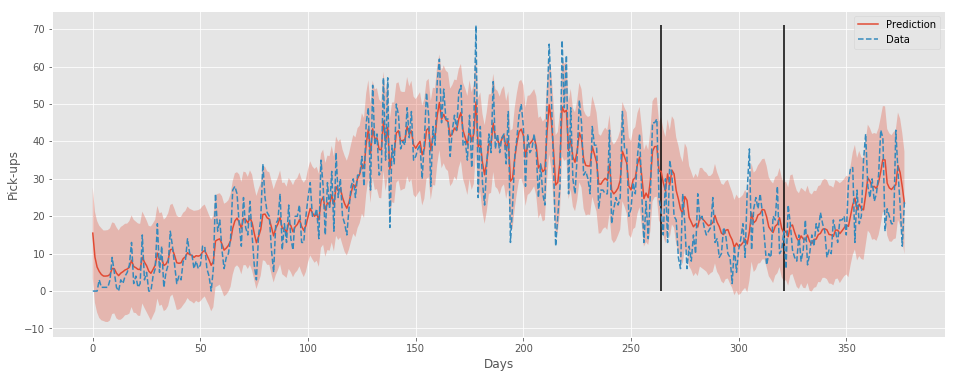

Epoch: 21, Loss: 1.173, Val Loss: 1.171, sigma: 0.351
Epoch: 22, Loss: 1.117, Val Loss: 1.058, sigma: 0.351
Epoch: 23, Loss: 1.119, Val Loss: 0.955, sigma: 0.351
Epoch: 24, Loss: 1.186, Val Loss: 1.149, sigma: 0.351
Epoch: 25, Loss: 1.193, Val Loss: 0.891, sigma: 0.351
Epoch: 26, Loss: 1.169, Val Loss: 1.024, sigma: 0.351
Epoch: 27, Loss: 1.195, Val Loss: 0.934, sigma: 0.351
Epoch: 28, Loss: 1.117, Val Loss: 0.883, sigma: 0.351
Epoch: 29, Loss: 1.141, Val Loss: 0.955, sigma: 0.351
Epoch: 30, Loss: 1.141, Val Loss: 1.011, sigma: 0.351
Epoch: 31, Loss: 1.186, Val Loss: 0.928, sigma: 0.351
Epoch: 32, Loss: 1.178, Val Loss: 1.066, sigma: 0.351
Epoch: 33, Loss: 1.206, Val Loss: 0.976, sigma: 0.351
Epoch: 34, Loss: 1.146, Val Loss: 1.054, sigma: 0.351
Epoch: 35, Loss: 1.175, Val Loss: 1.108, sigma: 0.351
Epoch: 36, Loss: 1.157, Val Loss: 0.870, sigma: 0.351
Epoch: 37, Loss: 1.151, Val Loss: 1.114, sigma: 0.351
Epoch: 38, Loss: 1.124, Val Loss: 1.025, sigma: 0.351
Epoch: 39, Loss: 1.126, Val 

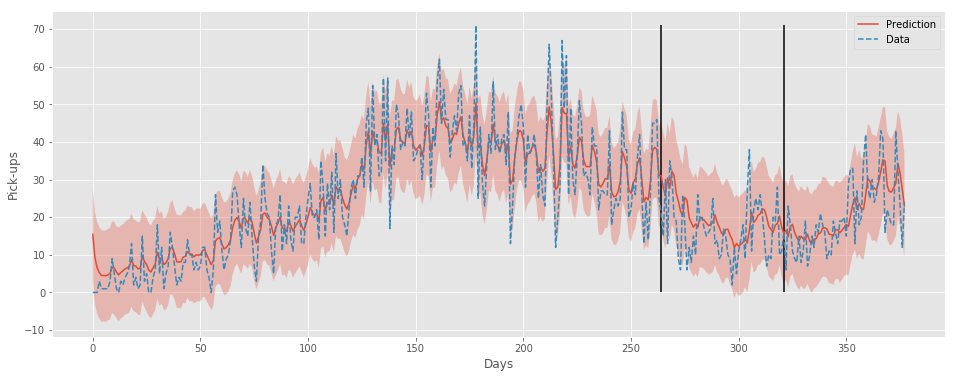

Epoch: 41, Loss: 1.199, Val Loss: 1.040, sigma: 0.351
Epoch: 42, Loss: 1.098, Val Loss: 1.071, sigma: 0.351
Epoch: 43, Loss: 1.238, Val Loss: 0.864, sigma: 0.351
Epoch: 44, Loss: 1.113, Val Loss: 0.925, sigma: 0.351
Epoch: 45, Loss: 1.165, Val Loss: 0.946, sigma: 0.351
Epoch: 46, Loss: 1.167, Val Loss: 0.946, sigma: 0.351
Epoch: 47, Loss: 1.181, Val Loss: 1.059, sigma: 0.351
Epoch: 48, Loss: 1.053, Val Loss: 1.113, sigma: 0.351
Epoch: 49, Loss: 1.116, Val Loss: 0.978, sigma: 0.351
Epoch: 50, Loss: 1.145, Val Loss: 0.918, sigma: 0.351
Epoch: 51, Loss: 1.087, Val Loss: 0.906, sigma: 0.351
Epoch: 52, Loss: 1.187, Val Loss: 1.029, sigma: 0.351
Epoch: 53, Loss: 1.151, Val Loss: 0.865, sigma: 0.351
Epoch: 54, Loss: 1.100, Val Loss: 0.820, sigma: 0.351
Epoch: 55, Loss: 1.161, Val Loss: 0.929, sigma: 0.351
Epoch: 56, Loss: 1.160, Val Loss: 0.976, sigma: 0.351
Epoch: 57, Loss: 1.144, Val Loss: 0.869, sigma: 0.351
Epoch: 58, Loss: 1.116, Val Loss: 0.789, sigma: 0.351
Epoch: 59, Loss: 1.125, Val 

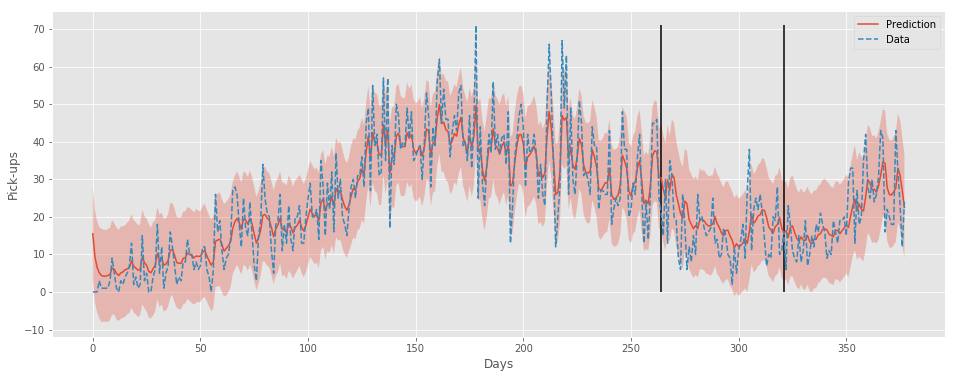

Epoch: 61, Loss: 1.110, Val Loss: 1.042, sigma: 0.351
Epoch: 62, Loss: 1.166, Val Loss: 1.108, sigma: 0.351
Epoch: 63, Loss: 1.155, Val Loss: 1.085, sigma: 0.351
Epoch: 64, Loss: 1.173, Val Loss: 1.128, sigma: 0.351
Epoch: 65, Loss: 1.175, Val Loss: 0.914, sigma: 0.351
Epoch: 66, Loss: 1.194, Val Loss: 1.097, sigma: 0.351
Epoch: 67, Loss: 1.208, Val Loss: 0.969, sigma: 0.351
Epoch: 68, Loss: 1.092, Val Loss: 1.122, sigma: 0.351
Epoch: 69, Loss: 1.166, Val Loss: 1.055, sigma: 0.351
Epoch: 70, Loss: 1.200, Val Loss: 0.959, sigma: 0.351
Epoch: 71, Loss: 1.203, Val Loss: 1.104, sigma: 0.351
Epoch: 72, Loss: 1.134, Val Loss: 1.125, sigma: 0.351
Epoch: 73, Loss: 1.184, Val Loss: 1.040, sigma: 0.351
Epoch: 74, Loss: 1.181, Val Loss: 0.972, sigma: 0.351
Epoch: 75, Loss: 1.219, Val Loss: 1.161, sigma: 0.351
Epoch: 76, Loss: 1.135, Val Loss: 0.898, sigma: 0.351
Epoch: 77, Loss: 1.155, Val Loss: 1.061, sigma: 0.351
Epoch: 78, Loss: 1.123, Val Loss: 1.000, sigma: 0.351
Epoch: 79, Loss: 1.110, Val 

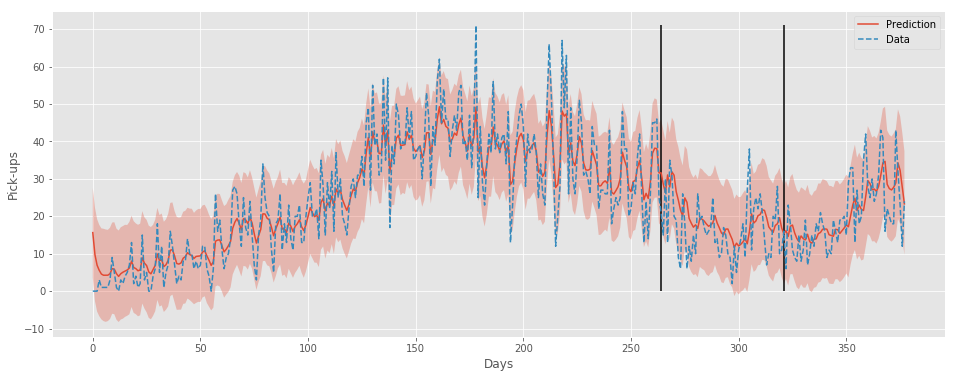

Epoch: 81, Loss: 1.189, Val Loss: 1.152, sigma: 0.351
Epoch: 82, Loss: 1.196, Val Loss: 0.947, sigma: 0.351
Epoch: 83, Loss: 1.209, Val Loss: 1.118, sigma: 0.351
Epoch: 84, Loss: 1.206, Val Loss: 0.982, sigma: 0.351
Epoch: 85, Loss: 1.066, Val Loss: 0.964, sigma: 0.351
Epoch: 86, Loss: 1.146, Val Loss: 0.962, sigma: 0.351
Epoch: 87, Loss: 1.170, Val Loss: 0.757, sigma: 0.351
Epoch: 88, Loss: 1.209, Val Loss: 1.002, sigma: 0.351
Epoch: 89, Loss: 1.119, Val Loss: 0.974, sigma: 0.351
Epoch: 90, Loss: 1.200, Val Loss: 0.929, sigma: 0.351
Epoch: 91, Loss: 1.153, Val Loss: 0.989, sigma: 0.351
Epoch: 92, Loss: 1.171, Val Loss: 0.951, sigma: 0.351
Epoch: 93, Loss: 1.230, Val Loss: 0.946, sigma: 0.351
Epoch: 94, Loss: 1.185, Val Loss: 1.116, sigma: 0.351
Epoch: 95, Loss: 1.134, Val Loss: 1.043, sigma: 0.351
Epoch: 96, Loss: 1.195, Val Loss: 0.873, sigma: 0.351
Epoch: 97, Loss: 1.160, Val Loss: 1.047, sigma: 0.351
Epoch: 98, Loss: 1.213, Val Loss: 1.051, sigma: 0.351
Epoch: 99, Loss: 1.121, Val 

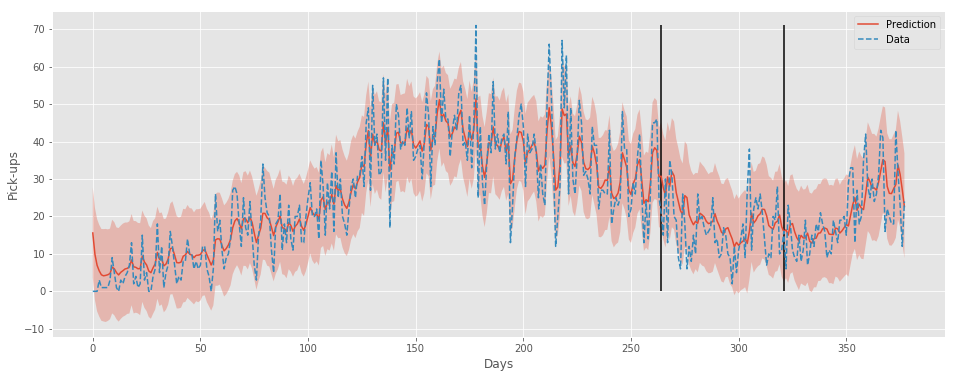

Epoch: 101, Loss: 1.206, Val Loss: 1.093, sigma: 0.351
Epoch: 102, Loss: 1.194, Val Loss: 1.017, sigma: 0.351
Epoch: 103, Loss: 1.131, Val Loss: 1.117, sigma: 0.351
Epoch: 104, Loss: 1.125, Val Loss: 1.105, sigma: 0.351
Epoch: 105, Loss: 1.141, Val Loss: 0.918, sigma: 0.351
Epoch: 106, Loss: 1.167, Val Loss: 0.907, sigma: 0.351
Epoch: 107, Loss: 1.055, Val Loss: 0.940, sigma: 0.351
Epoch: 108, Loss: 1.165, Val Loss: 0.960, sigma: 0.351
Epoch: 109, Loss: 1.152, Val Loss: 1.069, sigma: 0.351
Epoch: 110, Loss: 1.176, Val Loss: 0.980, sigma: 0.351
Epoch: 111, Loss: 1.167, Val Loss: 0.878, sigma: 0.351
Epoch: 112, Loss: 1.138, Val Loss: 1.224, sigma: 0.351
Epoch: 113, Loss: 1.179, Val Loss: 1.067, sigma: 0.351
Epoch: 114, Loss: 1.208, Val Loss: 1.036, sigma: 0.351
Epoch: 115, Loss: 1.125, Val Loss: 1.081, sigma: 0.351
Epoch: 116, Loss: 1.144, Val Loss: 0.846, sigma: 0.351
Epoch: 117, Loss: 1.182, Val Loss: 1.135, sigma: 0.351
Epoch: 118, Loss: 1.152, Val Loss: 1.053, sigma: 0.351
Epoch: 119

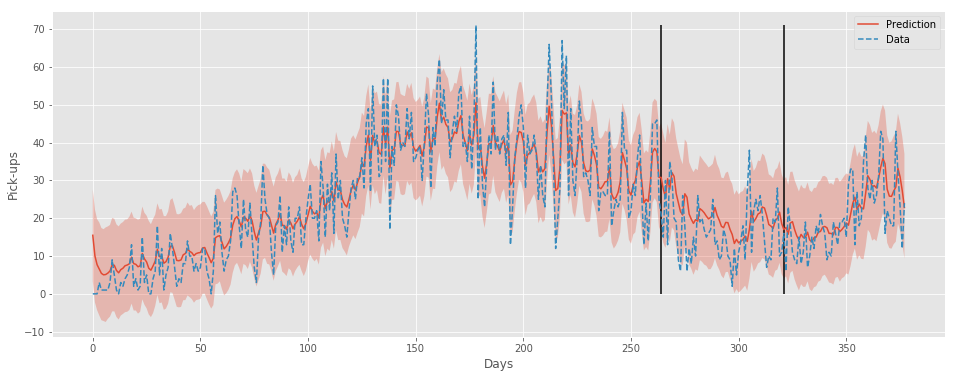

Epoch: 121, Loss: 1.191, Val Loss: 1.006, sigma: 0.351
Epoch: 122, Loss: 1.205, Val Loss: 1.103, sigma: 0.351
Epoch: 123, Loss: 1.125, Val Loss: 1.062, sigma: 0.351
Epoch: 124, Loss: 1.165, Val Loss: 1.015, sigma: 0.351
Epoch: 125, Loss: 1.167, Val Loss: 0.911, sigma: 0.351
Epoch: 126, Loss: 1.177, Val Loss: 0.935, sigma: 0.351
Epoch: 127, Loss: 1.117, Val Loss: 1.073, sigma: 0.351
Epoch: 128, Loss: 1.193, Val Loss: 0.971, sigma: 0.351
Epoch: 129, Loss: 1.097, Val Loss: 0.923, sigma: 0.351
Epoch: 130, Loss: 1.205, Val Loss: 1.069, sigma: 0.351
Epoch: 131, Loss: 1.154, Val Loss: 0.999, sigma: 0.351
Epoch: 132, Loss: 1.145, Val Loss: 0.971, sigma: 0.351
Epoch: 133, Loss: 1.205, Val Loss: 0.921, sigma: 0.351
Epoch: 134, Loss: 1.160, Val Loss: 1.097, sigma: 0.351
Epoch: 135, Loss: 1.159, Val Loss: 0.960, sigma: 0.351
Epoch: 136, Loss: 1.155, Val Loss: 1.178, sigma: 0.351
Epoch: 137, Loss: 1.141, Val Loss: 1.102, sigma: 0.351
Epoch: 138, Loss: 1.176, Val Loss: 1.131, sigma: 0.351
Epoch: 139

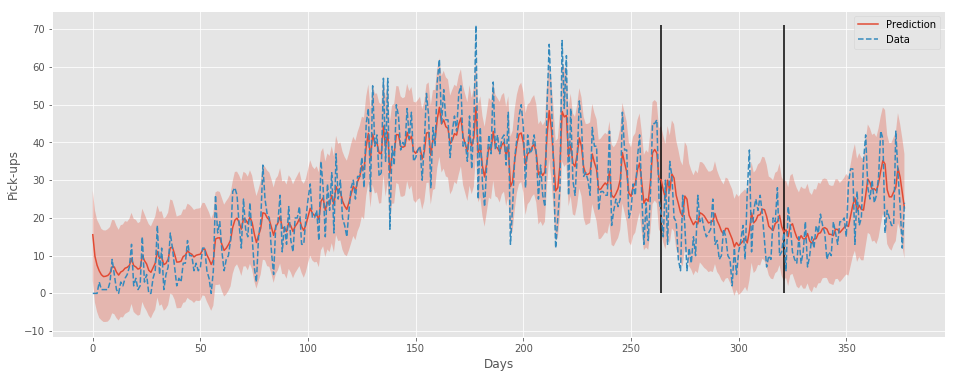

Epoch: 141, Loss: 1.112, Val Loss: 1.235, sigma: 0.351
Epoch: 142, Loss: 1.147, Val Loss: 0.858, sigma: 0.351
Epoch: 143, Loss: 1.123, Val Loss: 1.174, sigma: 0.351
Epoch: 144, Loss: 1.190, Val Loss: 1.073, sigma: 0.351
Epoch: 145, Loss: 1.085, Val Loss: 0.984, sigma: 0.351
Epoch: 146, Loss: 1.089, Val Loss: 1.163, sigma: 0.351
Epoch: 147, Loss: 1.198, Val Loss: 1.042, sigma: 0.351
Epoch: 148, Loss: 1.251, Val Loss: 1.121, sigma: 0.351
Epoch: 149, Loss: 1.180, Val Loss: 0.921, sigma: 0.351
Epoch: 150, Loss: 1.108, Val Loss: 0.996, sigma: 0.351
Epoch: 151, Loss: 1.089, Val Loss: 1.217, sigma: 0.351
Epoch: 152, Loss: 1.199, Val Loss: 0.963, sigma: 0.351
Epoch: 153, Loss: 1.170, Val Loss: 1.196, sigma: 0.351
Epoch: 154, Loss: 1.153, Val Loss: 0.875, sigma: 0.351
Epoch: 155, Loss: 1.140, Val Loss: 1.067, sigma: 0.351
Epoch: 156, Loss: 1.157, Val Loss: 0.843, sigma: 0.351
Epoch: 157, Loss: 1.161, Val Loss: 0.969, sigma: 0.351
Epoch: 158, Loss: 1.188, Val Loss: 1.036, sigma: 0.351
Epoch: 159

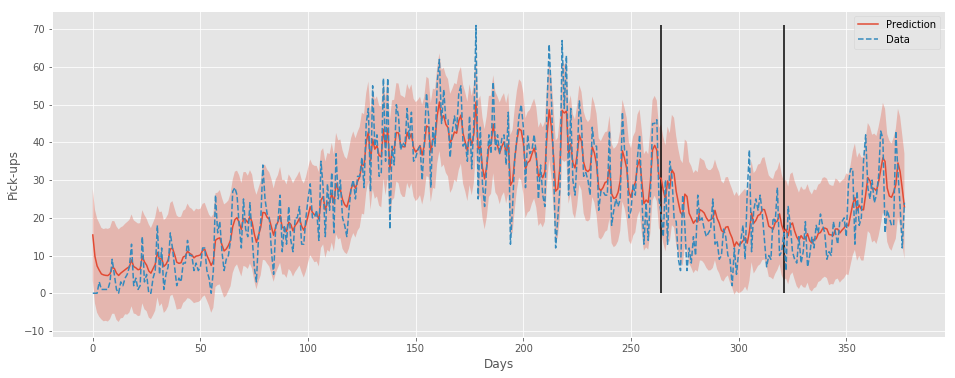

Epoch: 161, Loss: 1.210, Val Loss: 0.925, sigma: 0.351
Epoch: 162, Loss: 1.143, Val Loss: 0.953, sigma: 0.351
Epoch: 163, Loss: 1.150, Val Loss: 1.044, sigma: 0.351
Epoch: 164, Loss: 1.124, Val Loss: 0.852, sigma: 0.351
Epoch: 165, Loss: 1.172, Val Loss: 1.061, sigma: 0.351
Epoch: 166, Loss: 1.201, Val Loss: 1.111, sigma: 0.351
Epoch: 167, Loss: 1.138, Val Loss: 0.985, sigma: 0.351
Epoch: 168, Loss: 1.163, Val Loss: 0.968, sigma: 0.351
Epoch: 169, Loss: 1.206, Val Loss: 0.729, sigma: 0.351
Epoch: 170, Loss: 1.083, Val Loss: 1.054, sigma: 0.351
Epoch: 171, Loss: 1.214, Val Loss: 0.894, sigma: 0.351
Epoch: 172, Loss: 1.153, Val Loss: 1.073, sigma: 0.351
Epoch: 173, Loss: 1.166, Val Loss: 0.914, sigma: 0.351
Epoch: 174, Loss: 1.157, Val Loss: 1.047, sigma: 0.351
Epoch: 175, Loss: 1.153, Val Loss: 0.993, sigma: 0.351
Epoch: 176, Loss: 1.138, Val Loss: 1.076, sigma: 0.351
Epoch: 177, Loss: 1.161, Val Loss: 1.092, sigma: 0.351
Epoch: 178, Loss: 1.166, Val Loss: 1.053, sigma: 0.351
Epoch: 179

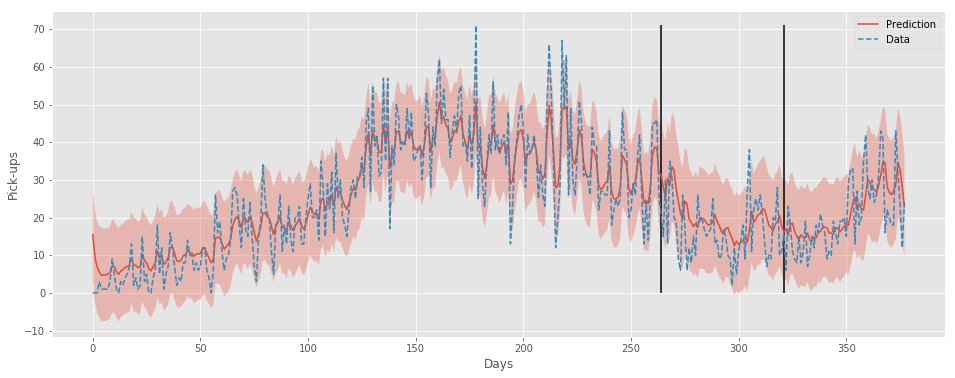

Epoch: 181, Loss: 1.162, Val Loss: 1.080, sigma: 0.351
Epoch: 182, Loss: 1.118, Val Loss: 1.040, sigma: 0.351
Epoch: 183, Loss: 1.143, Val Loss: 1.017, sigma: 0.351
Epoch: 184, Loss: 1.162, Val Loss: 1.102, sigma: 0.351
Epoch: 185, Loss: 1.173, Val Loss: 0.927, sigma: 0.351
Epoch: 186, Loss: 1.138, Val Loss: 1.067, sigma: 0.351
Epoch: 187, Loss: 1.225, Val Loss: 0.931, sigma: 0.351
Epoch: 188, Loss: 1.139, Val Loss: 0.898, sigma: 0.351
Epoch: 189, Loss: 1.188, Val Loss: 0.900, sigma: 0.351
Epoch: 190, Loss: 1.174, Val Loss: 0.942, sigma: 0.351
Epoch: 191, Loss: 1.212, Val Loss: 0.866, sigma: 0.351
Epoch: 192, Loss: 1.137, Val Loss: 1.147, sigma: 0.351
Epoch: 193, Loss: 1.181, Val Loss: 1.005, sigma: 0.351
Epoch: 194, Loss: 1.116, Val Loss: 0.949, sigma: 0.351
Epoch: 195, Loss: 1.162, Val Loss: 1.037, sigma: 0.351
Epoch: 196, Loss: 1.135, Val Loss: 0.975, sigma: 0.351
Epoch: 197, Loss: 1.166, Val Loss: 1.165, sigma: 0.351
Epoch: 198, Loss: 1.188, Val Loss: 1.140, sigma: 0.351
Epoch: 199

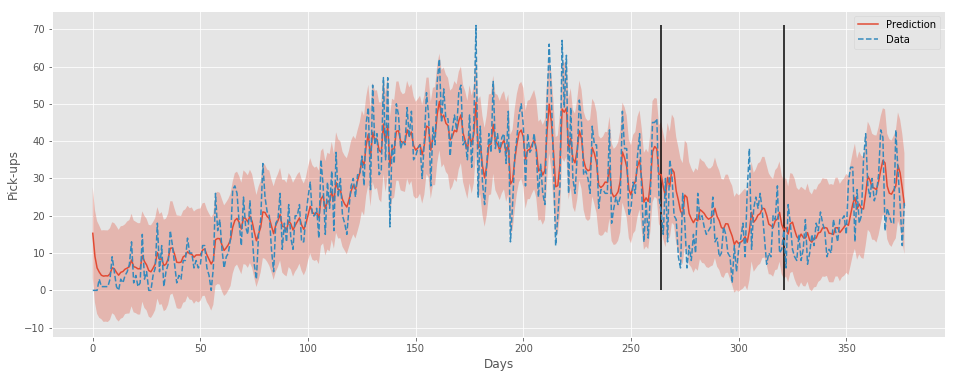

Epoch: 201, Loss: 1.142, Val Loss: 0.972, sigma: 0.351
Epoch: 202, Loss: 1.147, Val Loss: 0.947, sigma: 0.351
Epoch: 203, Loss: 1.147, Val Loss: 1.159, sigma: 0.351
Epoch: 204, Loss: 1.165, Val Loss: 0.909, sigma: 0.351
Epoch: 205, Loss: 1.121, Val Loss: 0.830, sigma: 0.351
Epoch: 206, Loss: 1.185, Val Loss: 0.931, sigma: 0.351
Epoch: 207, Loss: 1.167, Val Loss: 0.966, sigma: 0.351
Epoch: 208, Loss: 1.230, Val Loss: 0.985, sigma: 0.351
Epoch: 209, Loss: 1.181, Val Loss: 1.092, sigma: 0.351
Epoch: 210, Loss: 1.130, Val Loss: 1.004, sigma: 0.351
Epoch: 211, Loss: 1.243, Val Loss: 1.054, sigma: 0.351
Epoch: 212, Loss: 1.081, Val Loss: 1.241, sigma: 0.351
Epoch: 213, Loss: 1.216, Val Loss: 1.066, sigma: 0.351
Epoch: 214, Loss: 1.164, Val Loss: 0.999, sigma: 0.351
Epoch: 215, Loss: 1.157, Val Loss: 0.973, sigma: 0.351
Epoch: 216, Loss: 1.168, Val Loss: 1.074, sigma: 0.351
Epoch: 217, Loss: 1.176, Val Loss: 1.079, sigma: 0.351
Epoch: 218, Loss: 1.139, Val Loss: 0.938, sigma: 0.351
Epoch: 219

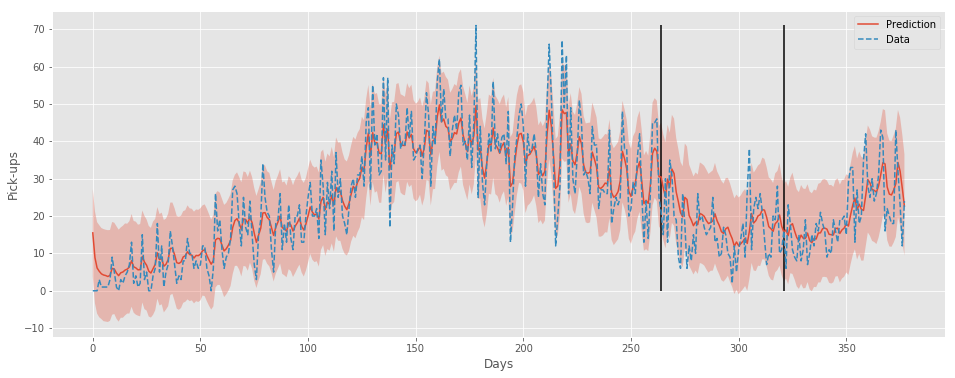

Epoch: 221, Loss: 1.165, Val Loss: 1.070, sigma: 0.351
Epoch: 222, Loss: 1.205, Val Loss: 1.038, sigma: 0.351
Epoch: 223, Loss: 1.149, Val Loss: 0.941, sigma: 0.351
Epoch: 224, Loss: 1.280, Val Loss: 0.811, sigma: 0.351
Epoch: 225, Loss: 1.129, Val Loss: 1.117, sigma: 0.351
Epoch: 226, Loss: 1.177, Val Loss: 0.940, sigma: 0.351
Epoch: 227, Loss: 1.159, Val Loss: 1.011, sigma: 0.351
Epoch: 228, Loss: 1.208, Val Loss: 0.766, sigma: 0.351
Epoch: 229, Loss: 1.160, Val Loss: 0.844, sigma: 0.351
Epoch: 230, Loss: 1.120, Val Loss: 0.824, sigma: 0.351
Epoch: 231, Loss: 1.164, Val Loss: 1.033, sigma: 0.351
Epoch: 232, Loss: 1.206, Val Loss: 1.046, sigma: 0.351
Epoch: 233, Loss: 1.146, Val Loss: 0.978, sigma: 0.351
Epoch: 234, Loss: 1.188, Val Loss: 1.030, sigma: 0.351
Epoch: 235, Loss: 1.160, Val Loss: 1.121, sigma: 0.351
Epoch: 236, Loss: 1.203, Val Loss: 1.108, sigma: 0.351
Epoch: 237, Loss: 1.145, Val Loss: 1.011, sigma: 0.351
Epoch: 238, Loss: 1.176, Val Loss: 0.941, sigma: 0.351
Epoch: 239

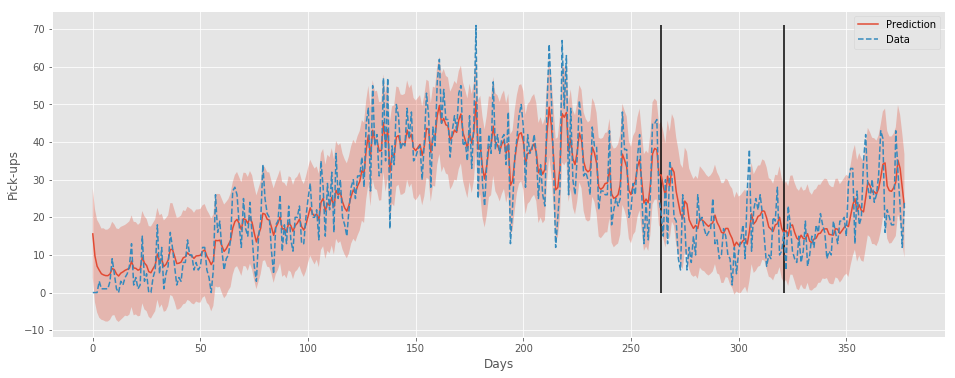

Epoch: 241, Loss: 1.088, Val Loss: 1.358, sigma: 0.351
Epoch: 242, Loss: 1.176, Val Loss: 1.103, sigma: 0.351
Epoch: 243, Loss: 1.162, Val Loss: 0.852, sigma: 0.351
Epoch: 244, Loss: 1.189, Val Loss: 0.931, sigma: 0.351
Epoch: 245, Loss: 1.160, Val Loss: 1.001, sigma: 0.351
Epoch: 246, Loss: 1.091, Val Loss: 0.872, sigma: 0.351
Epoch: 247, Loss: 1.090, Val Loss: 1.071, sigma: 0.351
Epoch: 248, Loss: 1.188, Val Loss: 1.085, sigma: 0.351
Epoch: 249, Loss: 1.153, Val Loss: 0.974, sigma: 0.351
Epoch: 250, Loss: 1.150, Val Loss: 0.942, sigma: 0.351
Epoch: 251, Loss: 1.146, Val Loss: 1.050, sigma: 0.351
Epoch: 252, Loss: 1.227, Val Loss: 0.986, sigma: 0.351
Epoch: 253, Loss: 1.121, Val Loss: 1.104, sigma: 0.351
Epoch: 254, Loss: 1.156, Val Loss: 1.129, sigma: 0.351
Epoch: 255, Loss: 1.144, Val Loss: 0.963, sigma: 0.351
Epoch: 256, Loss: 1.177, Val Loss: 0.920, sigma: 0.351
Epoch: 257, Loss: 1.144, Val Loss: 1.093, sigma: 0.351
Epoch: 258, Loss: 1.132, Val Loss: 0.914, sigma: 0.351
Epoch: 259

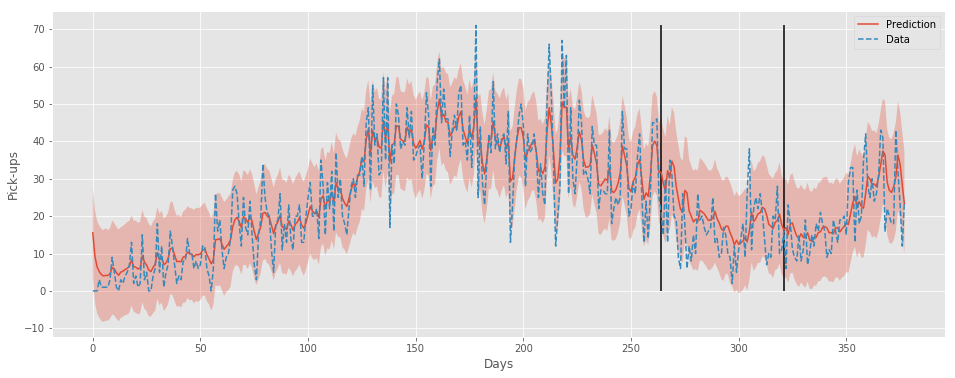

Epoch: 261, Loss: 1.188, Val Loss: 1.257, sigma: 0.351
Epoch: 262, Loss: 1.198, Val Loss: 1.033, sigma: 0.351
Epoch: 263, Loss: 1.249, Val Loss: 0.901, sigma: 0.351
Epoch: 264, Loss: 1.163, Val Loss: 0.973, sigma: 0.351
Epoch: 265, Loss: 1.194, Val Loss: 1.013, sigma: 0.351
Epoch: 266, Loss: 1.170, Val Loss: 1.145, sigma: 0.351
Epoch: 267, Loss: 1.106, Val Loss: 1.038, sigma: 0.351
Epoch: 268, Loss: 1.189, Val Loss: 1.091, sigma: 0.351
Epoch: 269, Loss: 1.204, Val Loss: 0.980, sigma: 0.351
Epoch: 270, Loss: 1.121, Val Loss: 0.977, sigma: 0.351
Epoch: 271, Loss: 1.097, Val Loss: 1.051, sigma: 0.351
Epoch: 272, Loss: 1.195, Val Loss: 1.070, sigma: 0.351
Epoch: 273, Loss: 1.161, Val Loss: 0.950, sigma: 0.351
Epoch: 274, Loss: 1.217, Val Loss: 1.118, sigma: 0.351
Epoch: 275, Loss: 1.165, Val Loss: 0.821, sigma: 0.351
Epoch: 276, Loss: 1.108, Val Loss: 1.087, sigma: 0.351
Epoch: 277, Loss: 1.159, Val Loss: 1.022, sigma: 0.351
Epoch: 278, Loss: 1.135, Val Loss: 1.025, sigma: 0.351
Epoch: 279

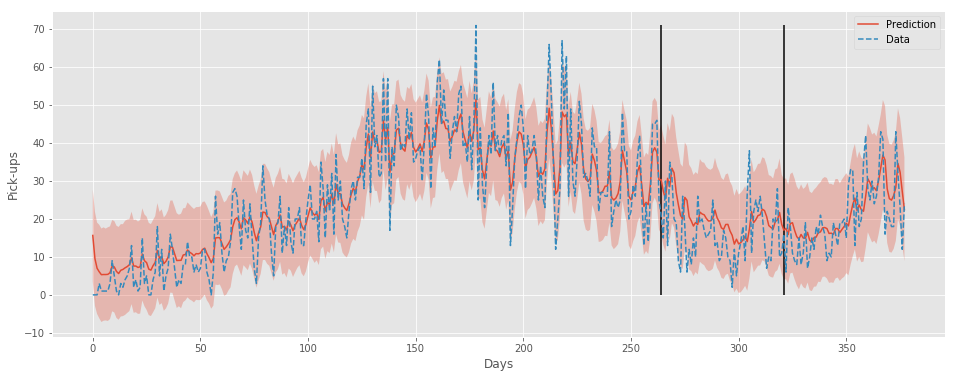

Epoch: 281, Loss: 1.194, Val Loss: 0.870, sigma: 0.351
Epoch: 282, Loss: 1.193, Val Loss: 0.972, sigma: 0.351
Epoch: 283, Loss: 1.179, Val Loss: 1.127, sigma: 0.351
Epoch: 284, Loss: 1.189, Val Loss: 1.031, sigma: 0.351
Epoch: 285, Loss: 1.128, Val Loss: 1.155, sigma: 0.351
Epoch: 286, Loss: 1.169, Val Loss: 1.034, sigma: 0.351
Epoch: 287, Loss: 1.174, Val Loss: 0.840, sigma: 0.351
Epoch: 288, Loss: 1.196, Val Loss: 1.155, sigma: 0.351
Epoch: 289, Loss: 1.087, Val Loss: 1.092, sigma: 0.351
Epoch: 290, Loss: 1.143, Val Loss: 1.234, sigma: 0.351
Epoch: 291, Loss: 1.089, Val Loss: 1.097, sigma: 0.351
Epoch: 292, Loss: 1.205, Val Loss: 1.000, sigma: 0.351
Epoch: 293, Loss: 1.122, Val Loss: 1.041, sigma: 0.351
Epoch: 294, Loss: 1.118, Val Loss: 1.158, sigma: 0.351
Epoch: 295, Loss: 1.137, Val Loss: 1.107, sigma: 0.351
Epoch: 296, Loss: 1.178, Val Loss: 0.877, sigma: 0.351
Epoch: 297, Loss: 1.125, Val Loss: 0.963, sigma: 0.351
Epoch: 298, Loss: 1.184, Val Loss: 1.037, sigma: 0.351
Epoch: 299

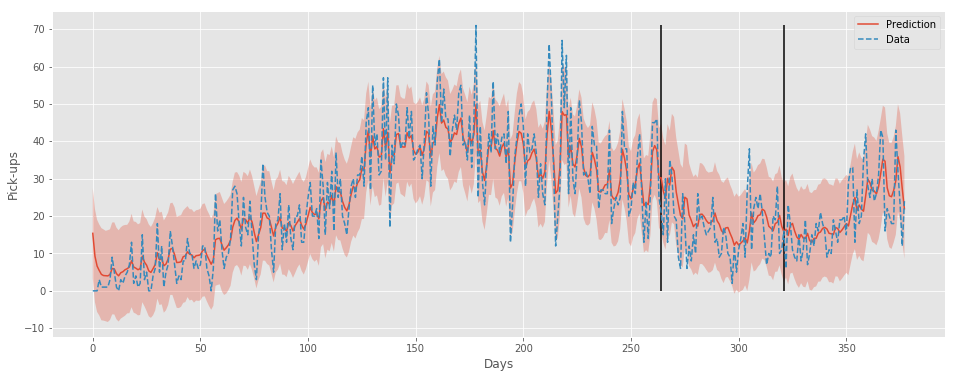

Epoch: 301, Loss: 1.186, Val Loss: 0.864, sigma: 0.351
Epoch: 302, Loss: 1.139, Val Loss: 0.983, sigma: 0.351
Epoch: 303, Loss: 1.180, Val Loss: 1.011, sigma: 0.351
Epoch: 304, Loss: 1.111, Val Loss: 1.072, sigma: 0.351
Epoch: 305, Loss: 1.109, Val Loss: 0.881, sigma: 0.351
Epoch: 306, Loss: 1.193, Val Loss: 1.113, sigma: 0.351
Epoch: 307, Loss: 1.165, Val Loss: 1.009, sigma: 0.351
Epoch: 308, Loss: 1.144, Val Loss: 0.870, sigma: 0.351
Epoch: 309, Loss: 1.184, Val Loss: 0.899, sigma: 0.351
Epoch: 310, Loss: 1.111, Val Loss: 1.091, sigma: 0.351
Epoch: 311, Loss: 1.129, Val Loss: 0.898, sigma: 0.351
Epoch: 312, Loss: 1.142, Val Loss: 0.907, sigma: 0.351
Epoch: 313, Loss: 1.132, Val Loss: 0.927, sigma: 0.351
Epoch: 314, Loss: 1.172, Val Loss: 0.973, sigma: 0.351
Epoch: 315, Loss: 1.204, Val Loss: 1.096, sigma: 0.351
Epoch: 316, Loss: 1.145, Val Loss: 0.999, sigma: 0.351
Epoch: 317, Loss: 1.126, Val Loss: 1.094, sigma: 0.351
Epoch: 318, Loss: 1.135, Val Loss: 1.059, sigma: 0.351
Epoch: 319

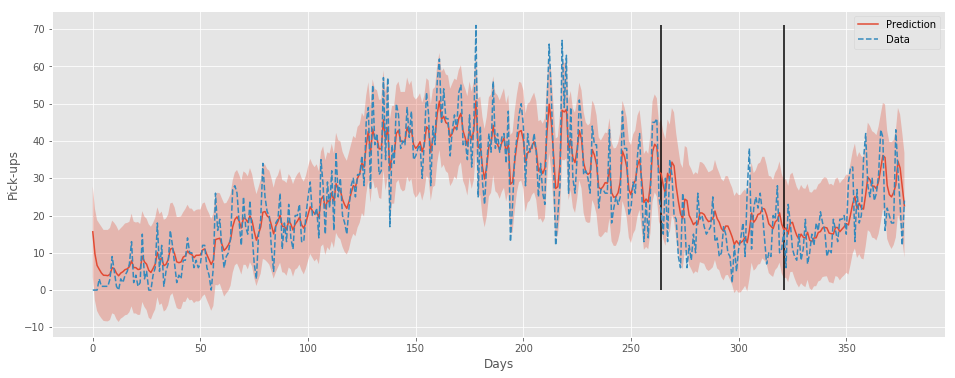

Epoch: 321, Loss: 1.150, Val Loss: 1.075, sigma: 0.351
Epoch: 322, Loss: 1.153, Val Loss: 0.968, sigma: 0.351
Epoch: 323, Loss: 1.159, Val Loss: 1.149, sigma: 0.351
Epoch: 324, Loss: 1.161, Val Loss: 0.994, sigma: 0.351
Epoch: 325, Loss: 1.178, Val Loss: 1.073, sigma: 0.351
Epoch: 326, Loss: 1.152, Val Loss: 1.089, sigma: 0.351
Epoch: 327, Loss: 1.125, Val Loss: 1.109, sigma: 0.351
Epoch: 328, Loss: 1.172, Val Loss: 1.058, sigma: 0.351
Epoch: 329, Loss: 1.152, Val Loss: 0.948, sigma: 0.351
Epoch: 330, Loss: 1.203, Val Loss: 0.993, sigma: 0.351
Epoch: 331, Loss: 1.108, Val Loss: 0.971, sigma: 0.351
Epoch: 332, Loss: 1.161, Val Loss: 0.822, sigma: 0.351
Epoch: 333, Loss: 1.134, Val Loss: 1.133, sigma: 0.351
Epoch: 334, Loss: 1.150, Val Loss: 0.899, sigma: 0.351
Epoch: 335, Loss: 1.178, Val Loss: 1.022, sigma: 0.351
Epoch: 336, Loss: 1.218, Val Loss: 0.982, sigma: 0.351
Epoch: 337, Loss: 1.166, Val Loss: 0.933, sigma: 0.351
Epoch: 338, Loss: 1.132, Val Loss: 1.002, sigma: 0.351
Epoch: 339

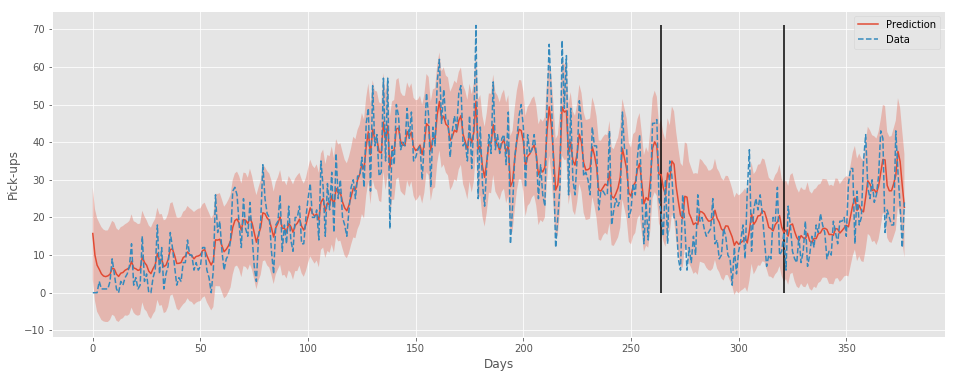

Epoch: 341, Loss: 1.200, Val Loss: 0.918, sigma: 0.351
Epoch: 342, Loss: 1.135, Val Loss: 1.221, sigma: 0.351
Epoch: 343, Loss: 1.108, Val Loss: 0.843, sigma: 0.351
Epoch: 344, Loss: 1.086, Val Loss: 0.888, sigma: 0.351
Epoch: 345, Loss: 1.100, Val Loss: 1.016, sigma: 0.351
Epoch: 346, Loss: 1.168, Val Loss: 0.992, sigma: 0.351
Epoch: 347, Loss: 1.221, Val Loss: 1.018, sigma: 0.351
Epoch: 348, Loss: 1.163, Val Loss: 1.028, sigma: 0.351
Epoch: 349, Loss: 1.286, Val Loss: 0.969, sigma: 0.351
Epoch: 350, Loss: 1.209, Val Loss: 1.059, sigma: 0.351
Epoch: 351, Loss: 1.167, Val Loss: 1.116, sigma: 0.351
Epoch: 352, Loss: 1.151, Val Loss: 0.963, sigma: 0.351
Epoch: 353, Loss: 1.113, Val Loss: 1.032, sigma: 0.351
Epoch: 354, Loss: 1.133, Val Loss: 0.962, sigma: 0.351
Epoch: 355, Loss: 1.090, Val Loss: 1.035, sigma: 0.351
Epoch: 356, Loss: 1.120, Val Loss: 0.914, sigma: 0.351
Epoch: 357, Loss: 1.150, Val Loss: 1.142, sigma: 0.351
Epoch: 358, Loss: 1.147, Val Loss: 0.944, sigma: 0.351
Epoch: 359

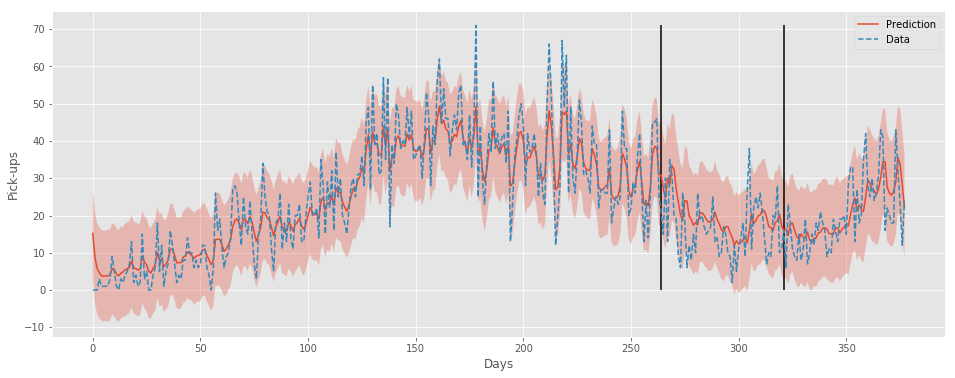

Epoch: 361, Loss: 1.136, Val Loss: 1.072, sigma: 0.351
Epoch: 362, Loss: 1.105, Val Loss: 1.000, sigma: 0.351
Epoch: 363, Loss: 1.120, Val Loss: 0.988, sigma: 0.351
Epoch: 364, Loss: 1.139, Val Loss: 1.102, sigma: 0.351
Epoch: 365, Loss: 1.107, Val Loss: 1.220, sigma: 0.351
Epoch: 366, Loss: 1.126, Val Loss: 0.994, sigma: 0.351
Epoch: 367, Loss: 1.132, Val Loss: 1.002, sigma: 0.351
Epoch: 368, Loss: 1.161, Val Loss: 0.992, sigma: 0.351
Epoch: 369, Loss: 1.278, Val Loss: 1.131, sigma: 0.351
Epoch: 370, Loss: 1.193, Val Loss: 0.923, sigma: 0.351
Epoch: 371, Loss: 1.186, Val Loss: 0.955, sigma: 0.351
Epoch: 372, Loss: 1.140, Val Loss: 1.310, sigma: 0.351
Epoch: 373, Loss: 1.206, Val Loss: 1.051, sigma: 0.351
Epoch: 374, Loss: 1.116, Val Loss: 1.125, sigma: 0.351
Epoch: 375, Loss: 1.161, Val Loss: 0.895, sigma: 0.351
Epoch: 376, Loss: 1.222, Val Loss: 1.094, sigma: 0.351
Epoch: 377, Loss: 1.165, Val Loss: 1.140, sigma: 0.351
Epoch: 378, Loss: 1.175, Val Loss: 0.882, sigma: 0.351
Epoch: 379

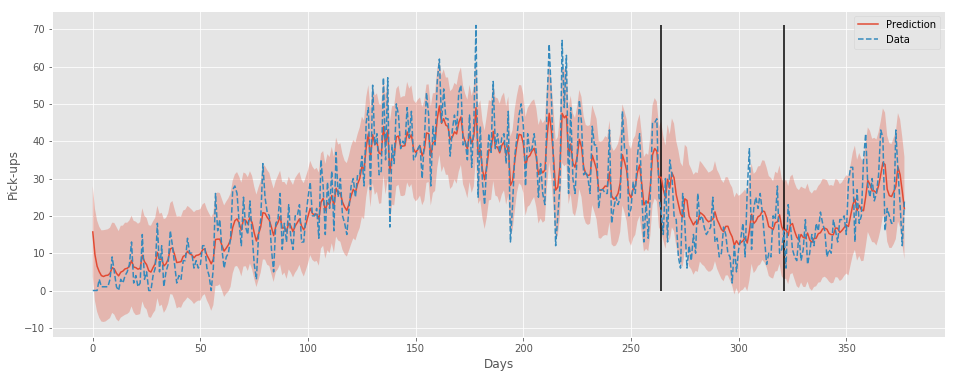

Epoch: 381, Loss: 1.175, Val Loss: 0.869, sigma: 0.351
Epoch: 382, Loss: 1.196, Val Loss: 1.110, sigma: 0.351
Epoch: 383, Loss: 1.171, Val Loss: 1.217, sigma: 0.351
Epoch: 384, Loss: 1.189, Val Loss: 1.108, sigma: 0.351
Epoch: 385, Loss: 1.159, Val Loss: 1.029, sigma: 0.351
Epoch: 386, Loss: 1.083, Val Loss: 0.927, sigma: 0.351
Epoch: 387, Loss: 1.105, Val Loss: 0.945, sigma: 0.351
Epoch: 388, Loss: 1.106, Val Loss: 0.997, sigma: 0.351
Epoch: 389, Loss: 1.164, Val Loss: 1.083, sigma: 0.351
Epoch: 390, Loss: 1.123, Val Loss: 1.055, sigma: 0.351
Epoch: 391, Loss: 1.183, Val Loss: 1.066, sigma: 0.351
Epoch: 392, Loss: 1.138, Val Loss: 1.100, sigma: 0.351
Epoch: 393, Loss: 1.113, Val Loss: 1.091, sigma: 0.351
Epoch: 394, Loss: 1.219, Val Loss: 1.007, sigma: 0.351
Epoch: 395, Loss: 1.144, Val Loss: 1.071, sigma: 0.351
Epoch: 396, Loss: 1.148, Val Loss: 0.969, sigma: 0.351
Epoch: 397, Loss: 1.156, Val Loss: 1.175, sigma: 0.351
Epoch: 398, Loss: 1.151, Val Loss: 1.158, sigma: 0.351
Epoch: 399

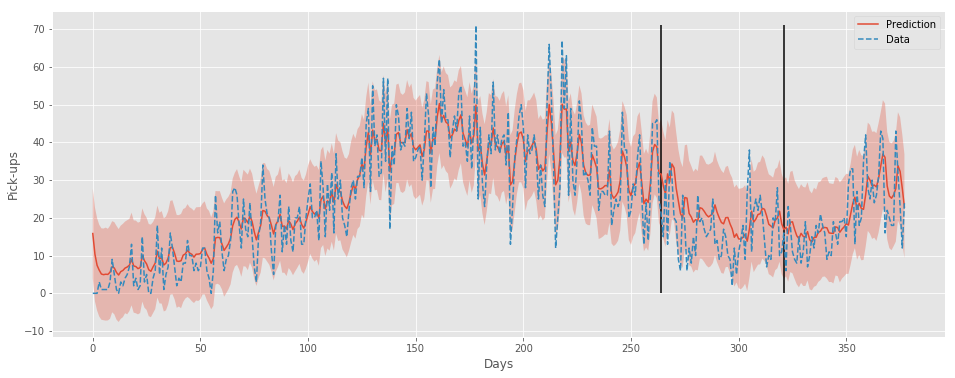

Epoch: 401, Loss: 1.141, Val Loss: 0.952, sigma: 0.351
Epoch: 402, Loss: 1.123, Val Loss: 0.894, sigma: 0.351
Epoch: 403, Loss: 1.142, Val Loss: 1.023, sigma: 0.351
Epoch: 404, Loss: 1.092, Val Loss: 0.921, sigma: 0.351
Epoch: 405, Loss: 1.113, Val Loss: 1.035, sigma: 0.351
Epoch: 406, Loss: 1.201, Val Loss: 1.022, sigma: 0.351
Epoch: 407, Loss: 1.172, Val Loss: 0.914, sigma: 0.351
Epoch: 408, Loss: 1.111, Val Loss: 0.939, sigma: 0.351
Epoch: 409, Loss: 1.121, Val Loss: 0.902, sigma: 0.351
Epoch: 410, Loss: 1.179, Val Loss: 1.082, sigma: 0.351
Epoch: 411, Loss: 1.191, Val Loss: 1.099, sigma: 0.351
Epoch: 412, Loss: 1.195, Val Loss: 0.947, sigma: 0.351
Epoch: 413, Loss: 1.136, Val Loss: 0.860, sigma: 0.351
Epoch: 414, Loss: 1.116, Val Loss: 0.870, sigma: 0.351
Epoch: 415, Loss: 1.149, Val Loss: 0.929, sigma: 0.351
Epoch: 416, Loss: 1.148, Val Loss: 0.957, sigma: 0.351
Epoch: 417, Loss: 1.189, Val Loss: 1.133, sigma: 0.351
Epoch: 418, Loss: 1.145, Val Loss: 1.128, sigma: 0.351
Epoch: 419

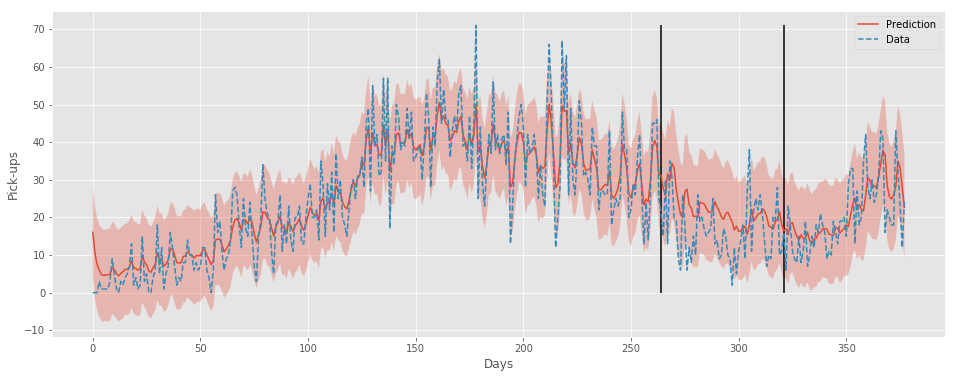

Epoch: 421, Loss: 1.103, Val Loss: 1.066, sigma: 0.351
Epoch: 422, Loss: 1.205, Val Loss: 0.918, sigma: 0.351
Epoch: 423, Loss: 1.188, Val Loss: 1.063, sigma: 0.351
Epoch: 424, Loss: 1.085, Val Loss: 0.976, sigma: 0.351
Epoch: 425, Loss: 1.076, Val Loss: 1.144, sigma: 0.351
Epoch: 426, Loss: 1.124, Val Loss: 1.060, sigma: 0.351
Epoch: 427, Loss: 1.092, Val Loss: 0.959, sigma: 0.351
Epoch: 428, Loss: 1.128, Val Loss: 0.840, sigma: 0.351
Epoch: 429, Loss: 1.127, Val Loss: 0.929, sigma: 0.351
Epoch: 430, Loss: 1.129, Val Loss: 0.917, sigma: 0.351
Epoch: 431, Loss: 1.123, Val Loss: 0.997, sigma: 0.351
Epoch: 432, Loss: 1.182, Val Loss: 0.920, sigma: 0.351
Epoch: 433, Loss: 1.164, Val Loss: 0.827, sigma: 0.351
Epoch: 434, Loss: 1.143, Val Loss: 0.934, sigma: 0.351
Epoch: 435, Loss: 1.209, Val Loss: 0.823, sigma: 0.351
Epoch: 436, Loss: 1.167, Val Loss: 0.889, sigma: 0.351
Epoch: 437, Loss: 1.167, Val Loss: 1.076, sigma: 0.351
Epoch: 438, Loss: 1.051, Val Loss: 0.952, sigma: 0.351
Epoch: 439

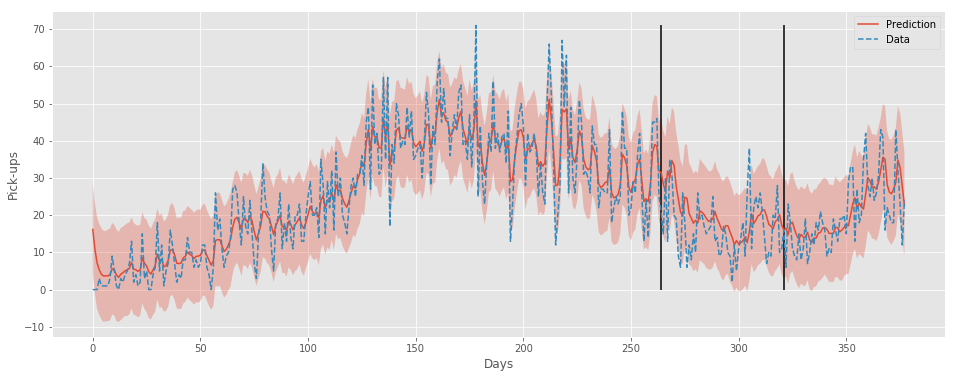

Epoch: 441, Loss: 1.198, Val Loss: 1.057, sigma: 0.351
Epoch: 442, Loss: 1.135, Val Loss: 1.001, sigma: 0.351
Epoch: 443, Loss: 1.180, Val Loss: 1.004, sigma: 0.351
Epoch: 444, Loss: 1.208, Val Loss: 1.105, sigma: 0.351
Epoch: 445, Loss: 1.096, Val Loss: 1.081, sigma: 0.351
Epoch: 446, Loss: 1.119, Val Loss: 1.017, sigma: 0.351
Epoch: 447, Loss: 1.121, Val Loss: 0.939, sigma: 0.351
Epoch: 448, Loss: 1.169, Val Loss: 1.000, sigma: 0.351
Epoch: 449, Loss: 1.085, Val Loss: 1.088, sigma: 0.351
Epoch: 450, Loss: 1.141, Val Loss: 0.926, sigma: 0.351
Epoch: 451, Loss: 1.092, Val Loss: 0.928, sigma: 0.351
Epoch: 452, Loss: 1.143, Val Loss: 0.966, sigma: 0.351
Epoch: 453, Loss: 1.209, Val Loss: 0.875, sigma: 0.351
Epoch: 454, Loss: 1.161, Val Loss: 0.930, sigma: 0.351
Epoch: 455, Loss: 1.117, Val Loss: 0.955, sigma: 0.351
Epoch: 456, Loss: 1.128, Val Loss: 1.049, sigma: 0.351
Epoch: 457, Loss: 1.181, Val Loss: 0.906, sigma: 0.351
Epoch: 458, Loss: 1.152, Val Loss: 1.081, sigma: 0.351
Epoch: 459

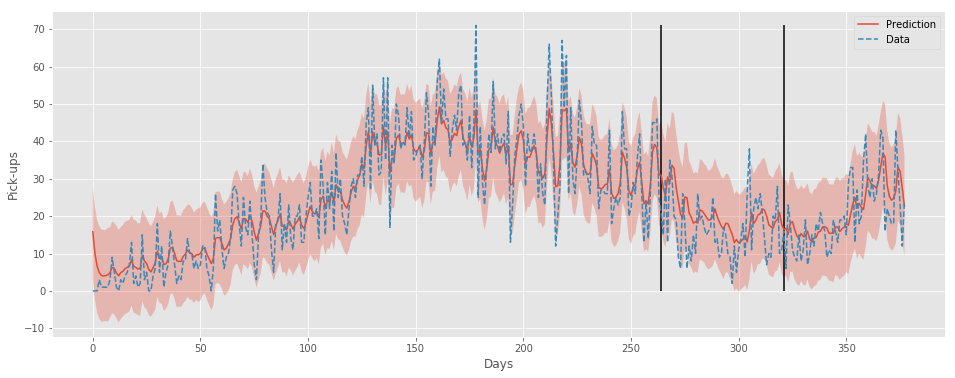

Epoch: 461, Loss: 1.097, Val Loss: 0.988, sigma: 0.351
Epoch: 462, Loss: 1.161, Val Loss: 1.094, sigma: 0.351
Epoch: 463, Loss: 1.103, Val Loss: 1.142, sigma: 0.351
Epoch: 464, Loss: 1.141, Val Loss: 1.000, sigma: 0.351
Epoch: 465, Loss: 1.169, Val Loss: 0.999, sigma: 0.351
Epoch: 466, Loss: 1.121, Val Loss: 1.098, sigma: 0.351
Epoch: 467, Loss: 1.120, Val Loss: 1.065, sigma: 0.351
Epoch: 468, Loss: 1.152, Val Loss: 1.033, sigma: 0.351
Epoch: 469, Loss: 1.243, Val Loss: 1.043, sigma: 0.351
Epoch: 470, Loss: 1.175, Val Loss: 1.176, sigma: 0.351
Epoch: 471, Loss: 1.171, Val Loss: 0.990, sigma: 0.351
Epoch: 472, Loss: 1.237, Val Loss: 0.963, sigma: 0.351
Epoch: 473, Loss: 1.171, Val Loss: 1.110, sigma: 0.351
Epoch: 474, Loss: 1.178, Val Loss: 1.036, sigma: 0.351
Epoch: 475, Loss: 1.109, Val Loss: 0.981, sigma: 0.351
Epoch: 476, Loss: 1.162, Val Loss: 1.089, sigma: 0.351
Epoch: 477, Loss: 1.102, Val Loss: 0.853, sigma: 0.351
Epoch: 478, Loss: 1.116, Val Loss: 1.034, sigma: 0.351
Epoch: 479

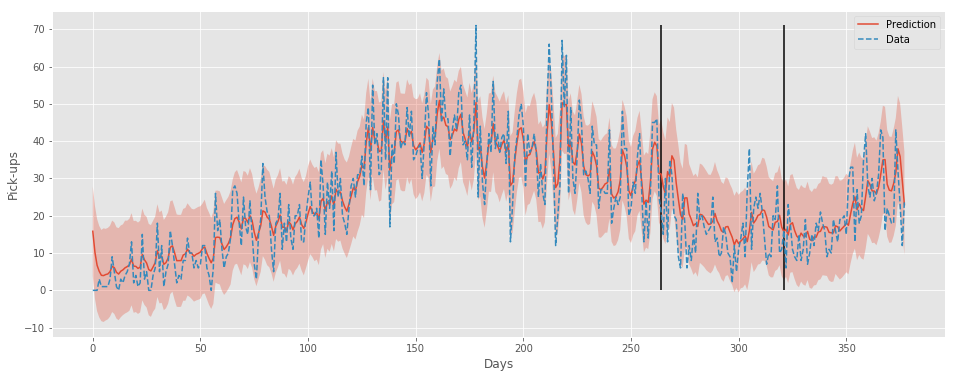

Epoch: 481, Loss: 1.156, Val Loss: 1.009, sigma: 0.351
Epoch: 482, Loss: 1.167, Val Loss: 0.982, sigma: 0.351
Epoch: 483, Loss: 1.165, Val Loss: 1.042, sigma: 0.351
Epoch: 484, Loss: 1.133, Val Loss: 0.932, sigma: 0.351
Epoch: 485, Loss: 1.124, Val Loss: 1.054, sigma: 0.351
Epoch: 486, Loss: 1.196, Val Loss: 1.067, sigma: 0.351
Epoch: 487, Loss: 1.103, Val Loss: 0.957, sigma: 0.351
Epoch: 488, Loss: 1.098, Val Loss: 0.902, sigma: 0.351
Epoch: 489, Loss: 1.150, Val Loss: 1.019, sigma: 0.351
Epoch: 490, Loss: 1.152, Val Loss: 0.821, sigma: 0.351
Epoch: 491, Loss: 1.092, Val Loss: 0.877, sigma: 0.351
Epoch: 492, Loss: 1.169, Val Loss: 1.137, sigma: 0.351
Epoch: 493, Loss: 1.203, Val Loss: 0.992, sigma: 0.351
Epoch: 494, Loss: 1.171, Val Loss: 1.055, sigma: 0.351
Epoch: 495, Loss: 1.112, Val Loss: 1.107, sigma: 0.351
Epoch: 496, Loss: 1.126, Val Loss: 1.212, sigma: 0.351
Epoch: 497, Loss: 1.145, Val Loss: 1.046, sigma: 0.351
Epoch: 498, Loss: 1.073, Val Loss: 1.025, sigma: 0.351
Epoch: 499

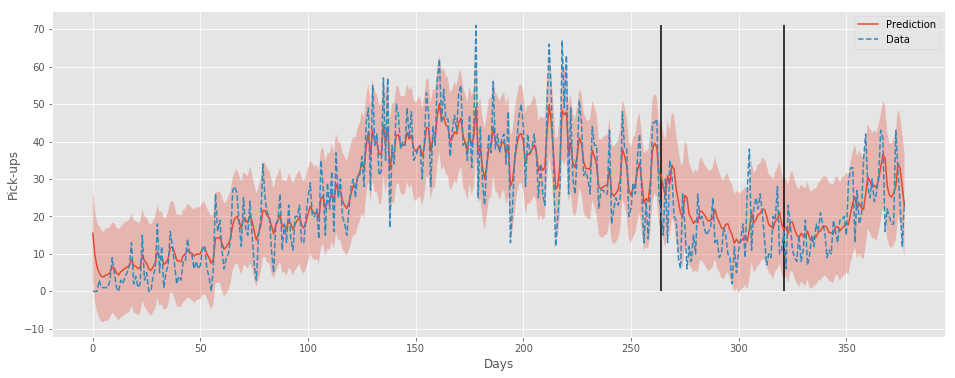

Epoch: 501, Loss: 1.057, Val Loss: 1.015, sigma: 0.351
Epoch: 502, Loss: 1.097, Val Loss: 0.940, sigma: 0.351
Epoch: 503, Loss: 1.115, Val Loss: 1.030, sigma: 0.351
Epoch: 504, Loss: 1.144, Val Loss: 1.061, sigma: 0.351
Epoch: 505, Loss: 1.121, Val Loss: 0.933, sigma: 0.351
Epoch: 506, Loss: 1.116, Val Loss: 0.997, sigma: 0.351
Epoch: 507, Loss: 1.102, Val Loss: 1.019, sigma: 0.351
Epoch: 508, Loss: 1.160, Val Loss: 1.011, sigma: 0.351
Epoch: 509, Loss: 1.166, Val Loss: 0.959, sigma: 0.351
Epoch: 510, Loss: 1.174, Val Loss: 0.984, sigma: 0.351
Epoch: 511, Loss: 1.178, Val Loss: 1.010, sigma: 0.351
Epoch: 512, Loss: 1.149, Val Loss: 0.961, sigma: 0.351
Epoch: 513, Loss: 1.192, Val Loss: 0.974, sigma: 0.351
Epoch: 514, Loss: 1.199, Val Loss: 1.021, sigma: 0.351
Epoch: 515, Loss: 1.138, Val Loss: 1.010, sigma: 0.351
Epoch: 516, Loss: 1.202, Val Loss: 0.909, sigma: 0.351
Epoch: 517, Loss: 1.199, Val Loss: 1.291, sigma: 0.351
Epoch: 518, Loss: 1.135, Val Loss: 0.768, sigma: 0.351
Epoch: 519

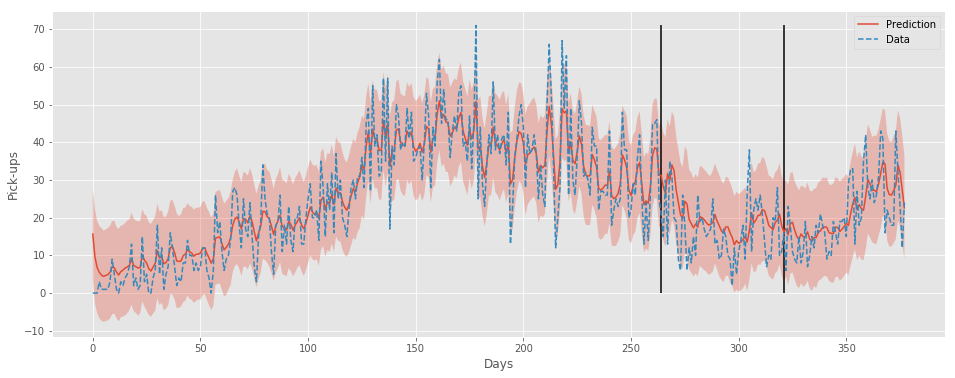

Epoch: 521, Loss: 1.114, Val Loss: 1.071, sigma: 0.351
Epoch: 522, Loss: 1.162, Val Loss: 1.105, sigma: 0.351
Epoch: 523, Loss: 1.118, Val Loss: 0.938, sigma: 0.351
Epoch: 524, Loss: 1.104, Val Loss: 1.053, sigma: 0.351
Epoch: 525, Loss: 1.187, Val Loss: 1.204, sigma: 0.351
Epoch: 526, Loss: 1.227, Val Loss: 0.853, sigma: 0.351
Epoch: 527, Loss: 1.117, Val Loss: 1.107, sigma: 0.351
Epoch: 528, Loss: 1.189, Val Loss: 0.936, sigma: 0.351
Epoch: 529, Loss: 1.268, Val Loss: 0.985, sigma: 0.351
Epoch: 530, Loss: 1.185, Val Loss: 0.980, sigma: 0.351
Epoch: 531, Loss: 1.233, Val Loss: 1.094, sigma: 0.351
Epoch: 532, Loss: 1.148, Val Loss: 1.099, sigma: 0.351
Epoch: 533, Loss: 1.150, Val Loss: 0.982, sigma: 0.351
Epoch: 534, Loss: 1.115, Val Loss: 1.047, sigma: 0.351
Epoch: 535, Loss: 1.115, Val Loss: 0.945, sigma: 0.351
Epoch: 536, Loss: 1.162, Val Loss: 0.981, sigma: 0.351
Epoch: 537, Loss: 1.179, Val Loss: 0.939, sigma: 0.351
Epoch: 538, Loss: 1.117, Val Loss: 1.237, sigma: 0.351
Epoch: 539

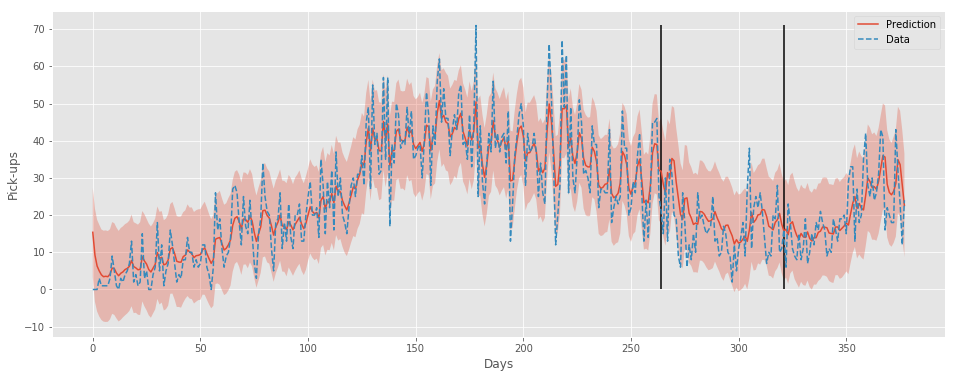

Epoch: 541, Loss: 1.142, Val Loss: 1.019, sigma: 0.351
Epoch: 542, Loss: 1.154, Val Loss: 0.999, sigma: 0.351
Epoch: 543, Loss: 1.068, Val Loss: 0.853, sigma: 0.351
Epoch: 544, Loss: 1.223, Val Loss: 1.089, sigma: 0.351
Epoch: 545, Loss: 1.191, Val Loss: 0.957, sigma: 0.351
Epoch: 546, Loss: 1.146, Val Loss: 0.923, sigma: 0.351
Epoch: 547, Loss: 1.109, Val Loss: 0.921, sigma: 0.351
Epoch: 548, Loss: 1.158, Val Loss: 0.962, sigma: 0.351
Epoch: 549, Loss: 1.122, Val Loss: 0.874, sigma: 0.351
Epoch: 550, Loss: 1.202, Val Loss: 1.093, sigma: 0.351
Epoch: 551, Loss: 1.129, Val Loss: 1.006, sigma: 0.351
Epoch: 552, Loss: 1.190, Val Loss: 1.008, sigma: 0.351
Epoch: 553, Loss: 1.121, Val Loss: 1.140, sigma: 0.351
Epoch: 554, Loss: 1.165, Val Loss: 0.970, sigma: 0.351
Epoch: 555, Loss: 1.096, Val Loss: 1.053, sigma: 0.351
Epoch: 556, Loss: 1.170, Val Loss: 1.118, sigma: 0.351
Epoch: 557, Loss: 1.162, Val Loss: 1.122, sigma: 0.351
Epoch: 558, Loss: 1.147, Val Loss: 1.080, sigma: 0.351
Epoch: 559

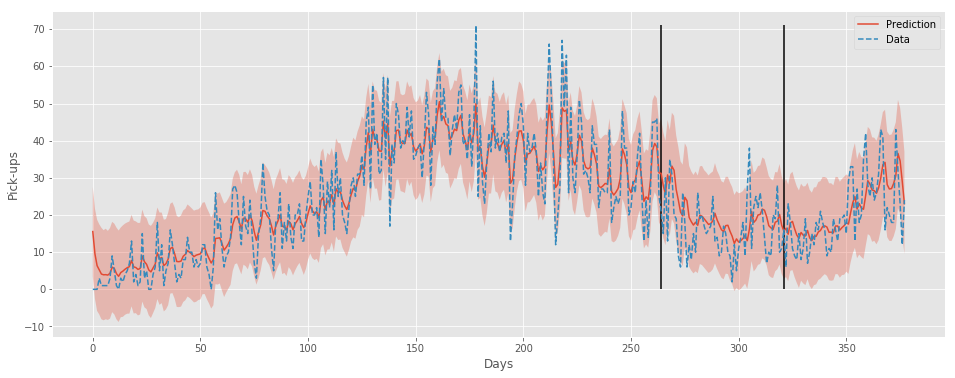

Epoch: 561, Loss: 1.143, Val Loss: 1.004, sigma: 0.351
Epoch: 562, Loss: 1.207, Val Loss: 1.021, sigma: 0.351
Epoch: 563, Loss: 1.070, Val Loss: 1.036, sigma: 0.351
Epoch: 564, Loss: 1.142, Val Loss: 1.007, sigma: 0.351
Epoch: 565, Loss: 1.090, Val Loss: 0.952, sigma: 0.351
Epoch: 566, Loss: 1.211, Val Loss: 1.232, sigma: 0.351
Epoch: 567, Loss: 1.207, Val Loss: 0.924, sigma: 0.351
Epoch: 568, Loss: 1.119, Val Loss: 1.114, sigma: 0.351
Epoch: 569, Loss: 1.158, Val Loss: 0.974, sigma: 0.351
Epoch: 570, Loss: 1.086, Val Loss: 1.027, sigma: 0.351
Epoch: 571, Loss: 1.155, Val Loss: 1.004, sigma: 0.351
Epoch: 572, Loss: 1.199, Val Loss: 0.973, sigma: 0.351
Epoch: 573, Loss: 1.219, Val Loss: 0.961, sigma: 0.351
Epoch: 574, Loss: 1.142, Val Loss: 1.241, sigma: 0.351
Epoch: 575, Loss: 1.128, Val Loss: 0.881, sigma: 0.351
Epoch: 576, Loss: 1.200, Val Loss: 0.867, sigma: 0.351
Epoch: 577, Loss: 1.164, Val Loss: 1.289, sigma: 0.351
Epoch: 578, Loss: 1.176, Val Loss: 1.018, sigma: 0.351
Epoch: 579

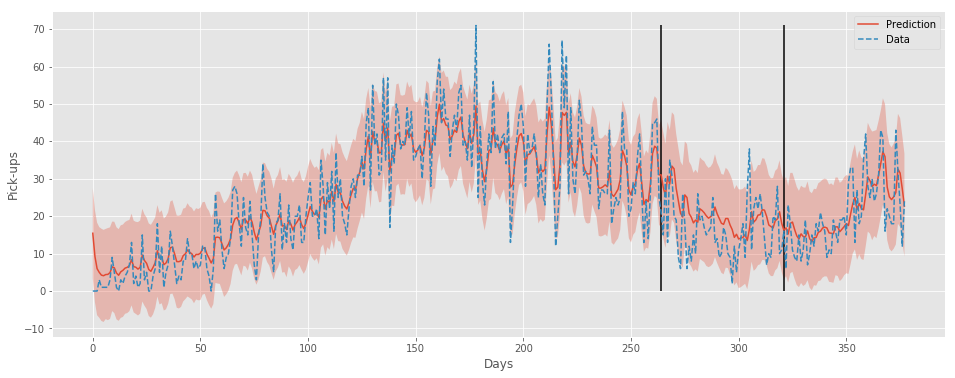

Epoch: 581, Loss: 1.196, Val Loss: 1.170, sigma: 0.351
Epoch: 582, Loss: 1.134, Val Loss: 0.946, sigma: 0.351
Epoch: 583, Loss: 1.175, Val Loss: 1.046, sigma: 0.351
Epoch: 584, Loss: 1.178, Val Loss: 0.943, sigma: 0.351
Epoch: 585, Loss: 1.086, Val Loss: 1.022, sigma: 0.351
Epoch: 586, Loss: 1.116, Val Loss: 1.076, sigma: 0.351
Epoch: 587, Loss: 1.162, Val Loss: 0.960, sigma: 0.351
Epoch: 588, Loss: 1.133, Val Loss: 1.054, sigma: 0.351
Epoch: 589, Loss: 1.131, Val Loss: 1.262, sigma: 0.351
Epoch: 590, Loss: 1.170, Val Loss: 1.091, sigma: 0.351
Epoch: 591, Loss: 1.143, Val Loss: 1.009, sigma: 0.351
Epoch: 592, Loss: 1.087, Val Loss: 1.114, sigma: 0.351
Epoch: 593, Loss: 1.169, Val Loss: 1.068, sigma: 0.351
Epoch: 594, Loss: 1.201, Val Loss: 0.836, sigma: 0.351
Epoch: 595, Loss: 1.228, Val Loss: 1.081, sigma: 0.351
Epoch: 596, Loss: 1.200, Val Loss: 1.079, sigma: 0.351
Epoch: 597, Loss: 1.161, Val Loss: 1.082, sigma: 0.351
Epoch: 598, Loss: 1.071, Val Loss: 0.986, sigma: 0.351
Epoch: 599

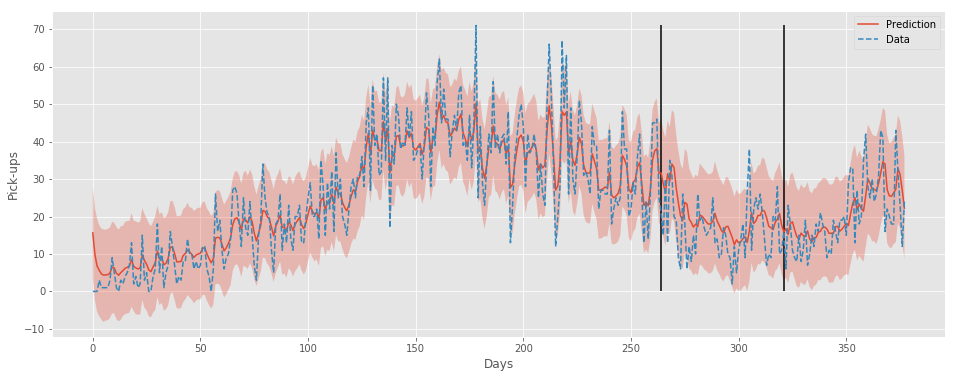

Epoch: 601, Loss: 1.129, Val Loss: 0.903, sigma: 0.351
Epoch: 602, Loss: 1.123, Val Loss: 0.983, sigma: 0.351
Epoch: 603, Loss: 1.225, Val Loss: 1.151, sigma: 0.351
Epoch: 604, Loss: 1.125, Val Loss: 1.013, sigma: 0.351
Epoch: 605, Loss: 1.162, Val Loss: 0.932, sigma: 0.351
Epoch: 606, Loss: 1.103, Val Loss: 0.996, sigma: 0.351
Epoch: 607, Loss: 1.120, Val Loss: 0.911, sigma: 0.351
Epoch: 608, Loss: 1.074, Val Loss: 1.022, sigma: 0.351
Epoch: 609, Loss: 1.139, Val Loss: 0.977, sigma: 0.351
Epoch: 610, Loss: 1.140, Val Loss: 0.963, sigma: 0.351
Epoch: 611, Loss: 1.118, Val Loss: 1.051, sigma: 0.351
Epoch: 612, Loss: 1.139, Val Loss: 1.001, sigma: 0.351
Epoch: 613, Loss: 1.117, Val Loss: 0.972, sigma: 0.351
Epoch: 614, Loss: 1.149, Val Loss: 0.927, sigma: 0.351
Epoch: 615, Loss: 1.170, Val Loss: 0.843, sigma: 0.351
Epoch: 616, Loss: 1.116, Val Loss: 1.189, sigma: 0.351
Epoch: 617, Loss: 1.162, Val Loss: 1.156, sigma: 0.351
Epoch: 618, Loss: 1.162, Val Loss: 0.947, sigma: 0.351
Epoch: 619

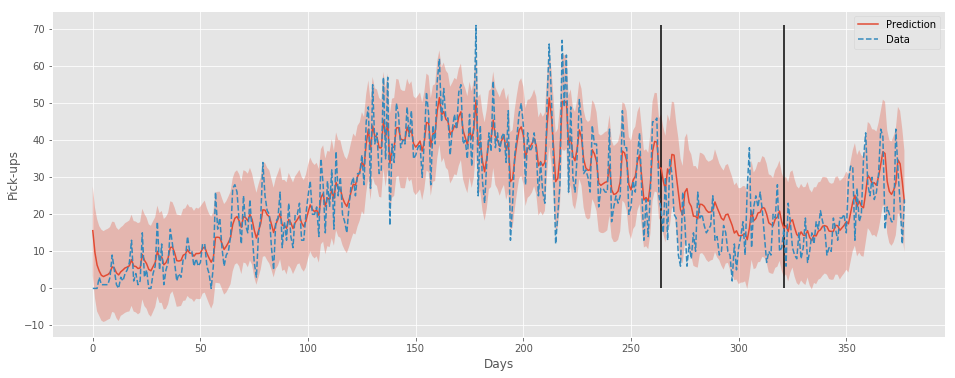

Epoch: 621, Loss: 1.131, Val Loss: 1.136, sigma: 0.351
Epoch: 622, Loss: 1.127, Val Loss: 1.031, sigma: 0.351
Epoch: 623, Loss: 1.183, Val Loss: 0.929, sigma: 0.351
Epoch: 624, Loss: 1.208, Val Loss: 1.180, sigma: 0.351
Epoch: 625, Loss: 1.165, Val Loss: 0.968, sigma: 0.351
Epoch: 626, Loss: 1.170, Val Loss: 0.950, sigma: 0.351
Epoch: 627, Loss: 1.116, Val Loss: 1.053, sigma: 0.351
Epoch: 628, Loss: 1.106, Val Loss: 1.052, sigma: 0.351
Epoch: 629, Loss: 1.192, Val Loss: 1.103, sigma: 0.351
Epoch: 630, Loss: 1.146, Val Loss: 1.085, sigma: 0.351
Epoch: 631, Loss: 1.125, Val Loss: 1.047, sigma: 0.351
Epoch: 632, Loss: 1.137, Val Loss: 0.989, sigma: 0.351
Epoch: 633, Loss: 1.093, Val Loss: 1.074, sigma: 0.351
Epoch: 634, Loss: 1.150, Val Loss: 0.979, sigma: 0.351
Epoch: 635, Loss: 1.129, Val Loss: 1.037, sigma: 0.351
Epoch: 636, Loss: 1.136, Val Loss: 1.197, sigma: 0.351
Epoch: 637, Loss: 1.115, Val Loss: 0.839, sigma: 0.351
Epoch: 638, Loss: 1.166, Val Loss: 0.787, sigma: 0.351
Epoch: 639

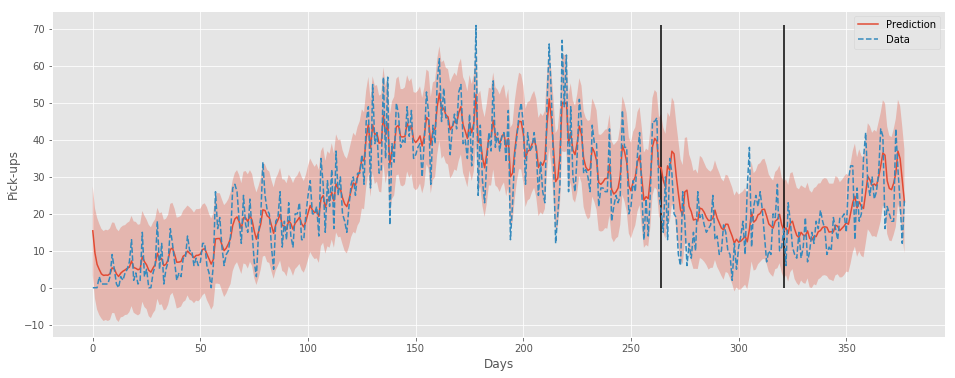

Epoch: 641, Loss: 1.175, Val Loss: 1.088, sigma: 0.351
Epoch: 642, Loss: 1.180, Val Loss: 1.009, sigma: 0.351
Epoch: 643, Loss: 1.116, Val Loss: 1.048, sigma: 0.351
Epoch: 644, Loss: 1.111, Val Loss: 1.008, sigma: 0.351
Epoch: 645, Loss: 1.167, Val Loss: 1.034, sigma: 0.351
Epoch: 646, Loss: 1.203, Val Loss: 1.060, sigma: 0.351
Epoch: 647, Loss: 1.167, Val Loss: 1.090, sigma: 0.351
Epoch: 648, Loss: 1.155, Val Loss: 0.832, sigma: 0.351
Epoch: 649, Loss: 1.138, Val Loss: 1.084, sigma: 0.351
Epoch: 650, Loss: 1.145, Val Loss: 1.034, sigma: 0.351
Epoch: 651, Loss: 1.188, Val Loss: 1.021, sigma: 0.351
Epoch: 652, Loss: 1.129, Val Loss: 1.033, sigma: 0.351
Epoch: 653, Loss: 1.078, Val Loss: 1.014, sigma: 0.351
Epoch: 654, Loss: 1.082, Val Loss: 1.044, sigma: 0.351
Epoch: 655, Loss: 1.182, Val Loss: 0.956, sigma: 0.351
Epoch: 656, Loss: 1.169, Val Loss: 0.888, sigma: 0.351
Epoch: 657, Loss: 1.145, Val Loss: 1.104, sigma: 0.351
Epoch: 658, Loss: 1.108, Val Loss: 0.968, sigma: 0.351
Epoch: 659

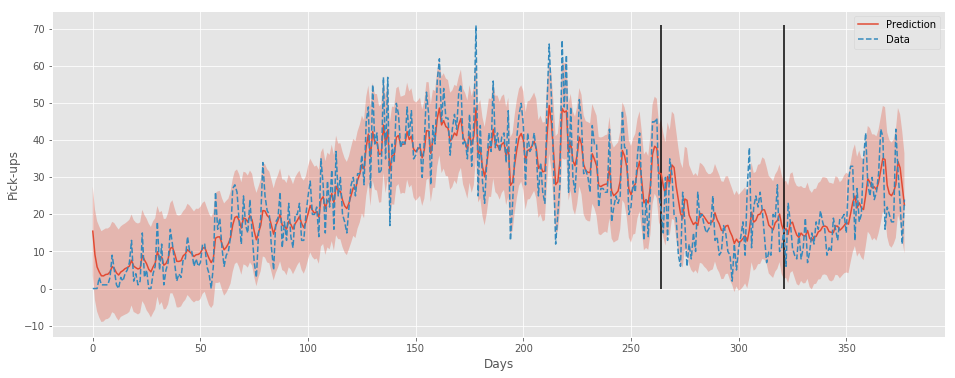

Epoch: 661, Loss: 1.125, Val Loss: 0.982, sigma: 0.351
Epoch: 662, Loss: 1.087, Val Loss: 0.938, sigma: 0.351
Epoch: 663, Loss: 1.081, Val Loss: 0.872, sigma: 0.351
Epoch: 664, Loss: 1.095, Val Loss: 1.134, sigma: 0.351
Epoch: 665, Loss: 1.233, Val Loss: 0.991, sigma: 0.351
Epoch: 666, Loss: 1.168, Val Loss: 1.115, sigma: 0.351
Epoch: 667, Loss: 1.106, Val Loss: 1.088, sigma: 0.351
Epoch: 668, Loss: 1.114, Val Loss: 0.825, sigma: 0.351
Epoch: 669, Loss: 1.080, Val Loss: 0.868, sigma: 0.351
Epoch: 670, Loss: 1.152, Val Loss: 1.138, sigma: 0.351
Epoch: 671, Loss: 1.130, Val Loss: 1.020, sigma: 0.351
Epoch: 672, Loss: 1.099, Val Loss: 0.978, sigma: 0.351
Epoch: 673, Loss: 1.194, Val Loss: 0.978, sigma: 0.351
Epoch: 674, Loss: 1.202, Val Loss: 0.968, sigma: 0.351
Epoch: 675, Loss: 1.163, Val Loss: 1.058, sigma: 0.351
Epoch: 676, Loss: 1.186, Val Loss: 0.829, sigma: 0.351
Epoch: 677, Loss: 1.199, Val Loss: 0.832, sigma: 0.351
Epoch: 678, Loss: 1.168, Val Loss: 1.124, sigma: 0.351
Epoch: 679

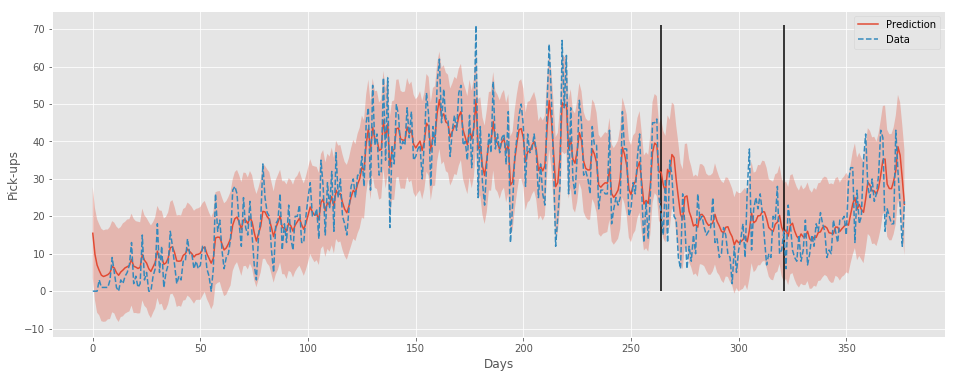

Epoch: 681, Loss: 1.179, Val Loss: 1.129, sigma: 0.351
Epoch: 682, Loss: 1.128, Val Loss: 1.101, sigma: 0.351
Epoch: 683, Loss: 1.158, Val Loss: 0.853, sigma: 0.351
Epoch: 684, Loss: 1.202, Val Loss: 0.941, sigma: 0.351
Epoch: 685, Loss: 1.085, Val Loss: 1.229, sigma: 0.351
Epoch: 686, Loss: 1.149, Val Loss: 0.947, sigma: 0.351
Epoch: 687, Loss: 1.130, Val Loss: 1.048, sigma: 0.351
Epoch: 688, Loss: 1.109, Val Loss: 1.091, sigma: 0.351
Epoch: 689, Loss: 1.134, Val Loss: 0.978, sigma: 0.351
Epoch: 690, Loss: 1.098, Val Loss: 1.051, sigma: 0.351
Epoch: 691, Loss: 1.107, Val Loss: 1.130, sigma: 0.351
Epoch: 692, Loss: 1.146, Val Loss: 1.144, sigma: 0.351
Epoch: 693, Loss: 1.095, Val Loss: 1.060, sigma: 0.351
Epoch: 694, Loss: 1.145, Val Loss: 1.024, sigma: 0.351
Epoch: 695, Loss: 1.119, Val Loss: 0.968, sigma: 0.351
Epoch: 696, Loss: 1.159, Val Loss: 1.058, sigma: 0.351
Epoch: 697, Loss: 1.181, Val Loss: 0.984, sigma: 0.351
Epoch: 698, Loss: 1.187, Val Loss: 1.124, sigma: 0.351
Epoch: 699

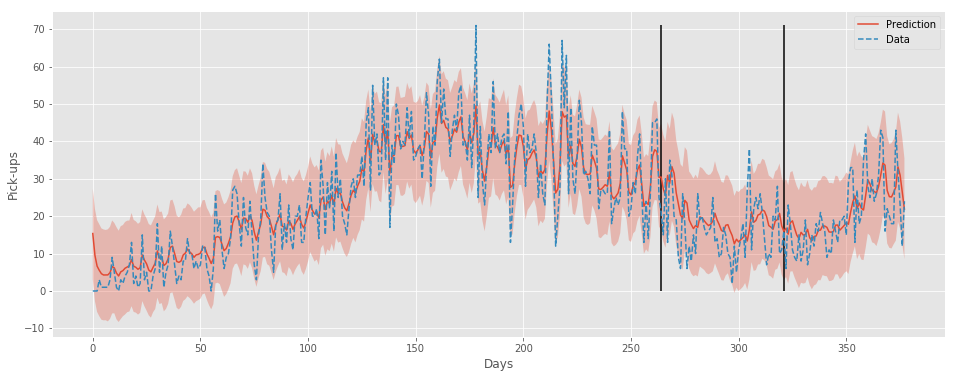

Epoch: 701, Loss: 1.065, Val Loss: 1.016, sigma: 0.351
Epoch: 702, Loss: 1.175, Val Loss: 0.939, sigma: 0.351
Epoch: 703, Loss: 1.112, Val Loss: 0.979, sigma: 0.351
Epoch: 704, Loss: 1.230, Val Loss: 0.942, sigma: 0.351
Epoch: 705, Loss: 1.254, Val Loss: 1.066, sigma: 0.351
Epoch: 706, Loss: 1.136, Val Loss: 1.005, sigma: 0.351
Epoch: 707, Loss: 1.201, Val Loss: 1.050, sigma: 0.351
Epoch: 708, Loss: 1.189, Val Loss: 0.838, sigma: 0.351
Epoch: 709, Loss: 1.230, Val Loss: 1.138, sigma: 0.351
Epoch: 710, Loss: 1.146, Val Loss: 1.051, sigma: 0.351
Epoch: 711, Loss: 1.189, Val Loss: 1.046, sigma: 0.351
Epoch: 712, Loss: 1.126, Val Loss: 1.123, sigma: 0.351
Epoch: 713, Loss: 1.120, Val Loss: 1.065, sigma: 0.351
Epoch: 714, Loss: 1.142, Val Loss: 1.121, sigma: 0.351
Epoch: 715, Loss: 1.138, Val Loss: 1.337, sigma: 0.351
Epoch: 716, Loss: 1.135, Val Loss: 1.105, sigma: 0.351
Epoch: 717, Loss: 1.213, Val Loss: 1.044, sigma: 0.351
Epoch: 718, Loss: 1.165, Val Loss: 0.917, sigma: 0.351
Epoch: 719

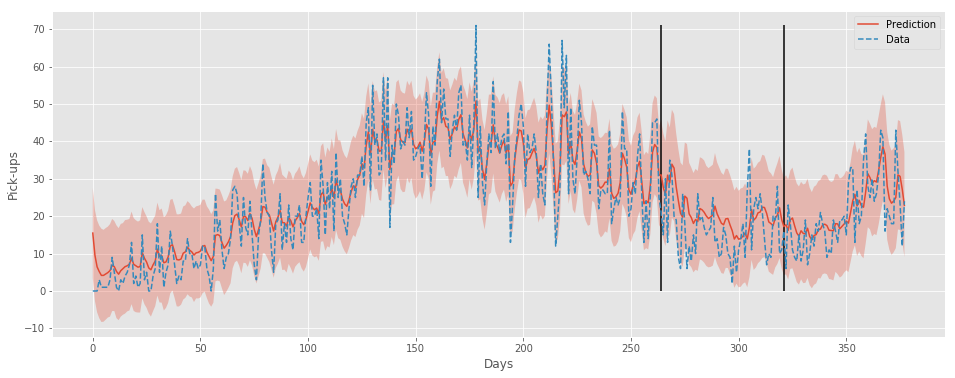

Epoch: 721, Loss: 1.167, Val Loss: 1.103, sigma: 0.351
Epoch: 722, Loss: 1.183, Val Loss: 1.099, sigma: 0.351
Epoch: 723, Loss: 1.182, Val Loss: 0.984, sigma: 0.351
Epoch: 724, Loss: 1.153, Val Loss: 0.921, sigma: 0.351
Epoch: 725, Loss: 1.169, Val Loss: 1.137, sigma: 0.351
Epoch: 726, Loss: 1.211, Val Loss: 0.836, sigma: 0.351
Epoch: 727, Loss: 1.122, Val Loss: 0.947, sigma: 0.351
Epoch: 728, Loss: 1.212, Val Loss: 1.114, sigma: 0.351
Epoch: 729, Loss: 1.101, Val Loss: 0.898, sigma: 0.351
Epoch: 730, Loss: 1.153, Val Loss: 0.950, sigma: 0.351
Epoch: 731, Loss: 1.140, Val Loss: 1.098, sigma: 0.351
Epoch: 732, Loss: 1.194, Val Loss: 1.046, sigma: 0.351
Epoch: 733, Loss: 1.112, Val Loss: 1.290, sigma: 0.351
Epoch: 734, Loss: 1.135, Val Loss: 1.100, sigma: 0.351
Epoch: 735, Loss: 1.126, Val Loss: 1.250, sigma: 0.351
Epoch: 736, Loss: 1.167, Val Loss: 0.880, sigma: 0.351
Epoch: 737, Loss: 1.108, Val Loss: 1.215, sigma: 0.351
Epoch: 738, Loss: 1.168, Val Loss: 1.036, sigma: 0.351
Epoch: 739

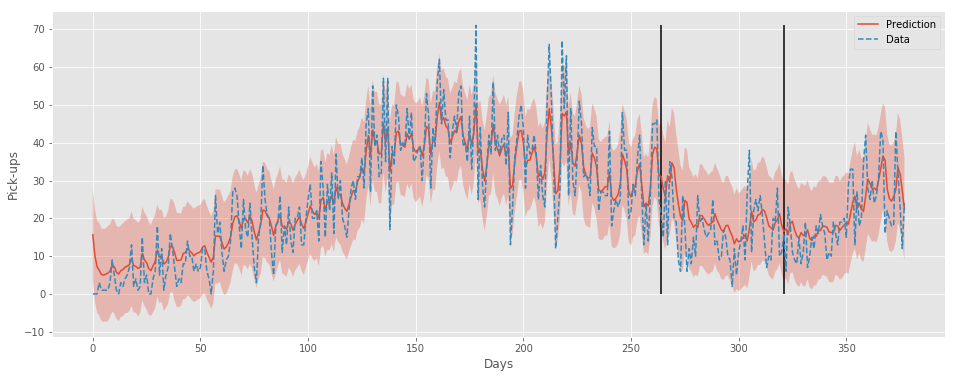

Epoch: 741, Loss: 1.093, Val Loss: 0.975, sigma: 0.351
Epoch: 742, Loss: 1.100, Val Loss: 0.810, sigma: 0.351
Epoch: 743, Loss: 1.182, Val Loss: 1.185, sigma: 0.351
Epoch: 744, Loss: 1.169, Val Loss: 0.893, sigma: 0.351
Epoch: 745, Loss: 1.125, Val Loss: 1.156, sigma: 0.351
Epoch: 746, Loss: 1.102, Val Loss: 1.104, sigma: 0.351
Epoch: 747, Loss: 1.133, Val Loss: 0.959, sigma: 0.351
Epoch: 748, Loss: 1.146, Val Loss: 1.171, sigma: 0.351
Epoch: 749, Loss: 1.102, Val Loss: 1.042, sigma: 0.351
Epoch: 750, Loss: 1.152, Val Loss: 0.979, sigma: 0.351
Epoch: 751, Loss: 1.203, Val Loss: 1.102, sigma: 0.351
Epoch: 752, Loss: 1.161, Val Loss: 1.024, sigma: 0.351
Epoch: 753, Loss: 1.140, Val Loss: 1.085, sigma: 0.351
Epoch: 754, Loss: 1.156, Val Loss: 0.899, sigma: 0.351
Epoch: 755, Loss: 1.234, Val Loss: 1.041, sigma: 0.351
Epoch: 756, Loss: 1.083, Val Loss: 1.033, sigma: 0.351
Epoch: 757, Loss: 1.160, Val Loss: 0.984, sigma: 0.351
Epoch: 758, Loss: 1.102, Val Loss: 1.071, sigma: 0.351
Epoch: 759

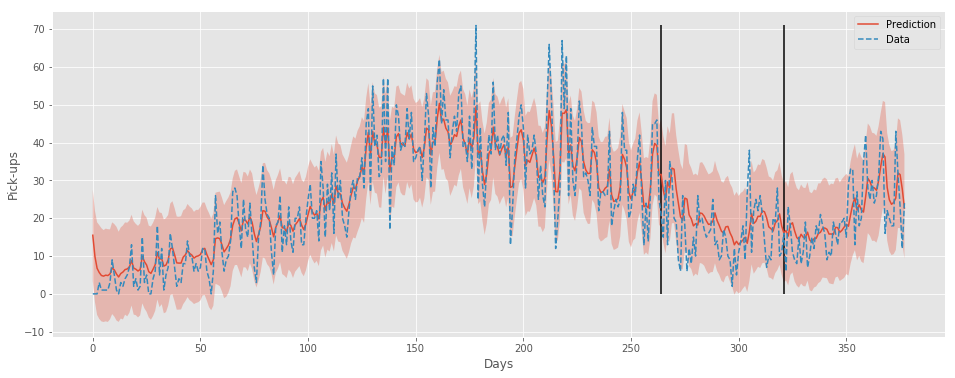

Epoch: 761, Loss: 1.121, Val Loss: 1.049, sigma: 0.351
Epoch: 762, Loss: 1.150, Val Loss: 1.107, sigma: 0.351
Epoch: 763, Loss: 1.175, Val Loss: 0.957, sigma: 0.351
Epoch: 764, Loss: 1.152, Val Loss: 1.121, sigma: 0.351
Epoch: 765, Loss: 1.115, Val Loss: 1.018, sigma: 0.351
Epoch: 766, Loss: 1.173, Val Loss: 0.952, sigma: 0.351
Epoch: 767, Loss: 1.118, Val Loss: 0.972, sigma: 0.351
Epoch: 768, Loss: 1.089, Val Loss: 0.926, sigma: 0.351
Epoch: 769, Loss: 1.109, Val Loss: 1.053, sigma: 0.351
Epoch: 770, Loss: 1.140, Val Loss: 1.216, sigma: 0.351
Epoch: 771, Loss: 1.179, Val Loss: 0.910, sigma: 0.351
Epoch: 772, Loss: 1.235, Val Loss: 0.943, sigma: 0.351
Epoch: 773, Loss: 1.133, Val Loss: 1.029, sigma: 0.351
Epoch: 774, Loss: 1.115, Val Loss: 1.021, sigma: 0.351
Epoch: 775, Loss: 1.147, Val Loss: 1.038, sigma: 0.351
Epoch: 776, Loss: 1.135, Val Loss: 1.095, sigma: 0.351
Epoch: 777, Loss: 1.126, Val Loss: 0.904, sigma: 0.351
Epoch: 778, Loss: 1.253, Val Loss: 1.053, sigma: 0.351
Epoch: 779

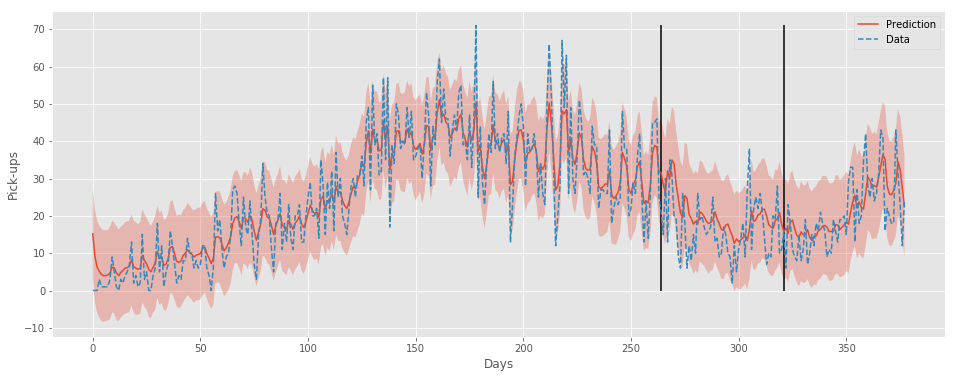

Epoch: 781, Loss: 1.105, Val Loss: 0.943, sigma: 0.351
Epoch: 782, Loss: 1.073, Val Loss: 1.011, sigma: 0.351
Epoch: 783, Loss: 1.112, Val Loss: 0.949, sigma: 0.351
Epoch: 784, Loss: 1.172, Val Loss: 1.007, sigma: 0.351
Epoch: 785, Loss: 1.159, Val Loss: 0.940, sigma: 0.351
Epoch: 786, Loss: 1.114, Val Loss: 1.169, sigma: 0.351
Epoch: 787, Loss: 1.105, Val Loss: 1.122, sigma: 0.351
Epoch: 788, Loss: 1.094, Val Loss: 1.082, sigma: 0.351
Epoch: 789, Loss: 1.122, Val Loss: 1.080, sigma: 0.351
Epoch: 790, Loss: 1.075, Val Loss: 1.004, sigma: 0.351
Epoch: 791, Loss: 1.210, Val Loss: 1.002, sigma: 0.351
Epoch: 792, Loss: 1.155, Val Loss: 0.980, sigma: 0.351
Epoch: 793, Loss: 1.222, Val Loss: 0.933, sigma: 0.351
Epoch: 794, Loss: 1.109, Val Loss: 0.992, sigma: 0.351
Epoch: 795, Loss: 1.152, Val Loss: 0.854, sigma: 0.351
Epoch: 796, Loss: 1.116, Val Loss: 1.160, sigma: 0.351
Epoch: 797, Loss: 1.175, Val Loss: 0.809, sigma: 0.351
Epoch: 798, Loss: 1.151, Val Loss: 0.978, sigma: 0.351
Epoch: 799

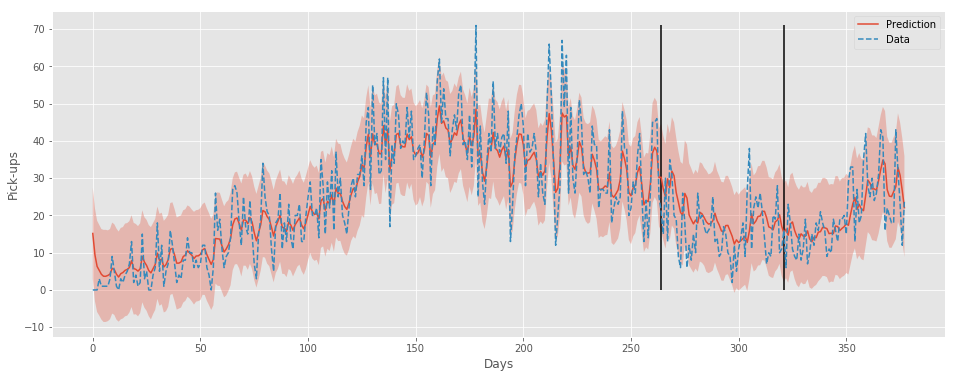

Epoch: 801, Loss: 1.106, Val Loss: 1.004, sigma: 0.351
Epoch: 802, Loss: 1.139, Val Loss: 0.932, sigma: 0.351
Epoch: 803, Loss: 1.217, Val Loss: 0.955, sigma: 0.351
Epoch: 804, Loss: 1.179, Val Loss: 0.846, sigma: 0.351
Epoch: 805, Loss: 1.154, Val Loss: 1.077, sigma: 0.351
Epoch: 806, Loss: 1.130, Val Loss: 1.077, sigma: 0.351
Epoch: 807, Loss: 1.186, Val Loss: 1.246, sigma: 0.351
Epoch: 808, Loss: 1.146, Val Loss: 0.943, sigma: 0.351
Epoch: 809, Loss: 1.158, Val Loss: 0.937, sigma: 0.351
Epoch: 810, Loss: 1.104, Val Loss: 0.848, sigma: 0.351
Epoch: 811, Loss: 1.167, Val Loss: 1.065, sigma: 0.351
Epoch: 812, Loss: 1.066, Val Loss: 0.983, sigma: 0.351
Epoch: 813, Loss: 1.148, Val Loss: 1.028, sigma: 0.351
Epoch: 814, Loss: 1.217, Val Loss: 0.800, sigma: 0.351
Epoch: 815, Loss: 1.121, Val Loss: 1.031, sigma: 0.351
Epoch: 816, Loss: 1.182, Val Loss: 1.024, sigma: 0.351
Epoch: 817, Loss: 1.249, Val Loss: 0.962, sigma: 0.351
Epoch: 818, Loss: 1.057, Val Loss: 0.970, sigma: 0.351
Epoch: 819

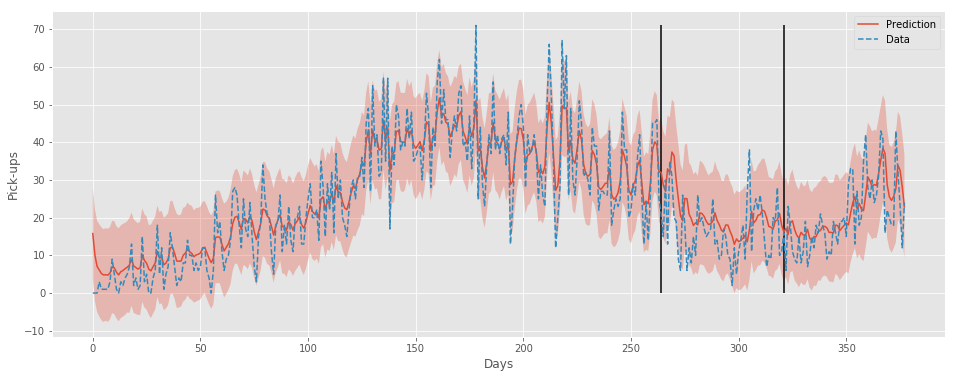

Epoch: 821, Loss: 1.159, Val Loss: 1.084, sigma: 0.351
Epoch: 822, Loss: 1.209, Val Loss: 1.098, sigma: 0.351
Epoch: 823, Loss: 1.146, Val Loss: 1.001, sigma: 0.351
Epoch: 824, Loss: 1.133, Val Loss: 1.004, sigma: 0.351
Epoch: 825, Loss: 1.178, Val Loss: 1.007, sigma: 0.351
Epoch: 826, Loss: 1.141, Val Loss: 1.048, sigma: 0.351
Epoch: 827, Loss: 1.083, Val Loss: 1.004, sigma: 0.351
Epoch: 828, Loss: 1.156, Val Loss: 0.960, sigma: 0.351
Epoch: 829, Loss: 1.190, Val Loss: 0.925, sigma: 0.351
Epoch: 830, Loss: 1.142, Val Loss: 1.196, sigma: 0.351
Epoch: 831, Loss: 1.167, Val Loss: 1.137, sigma: 0.351
Epoch: 832, Loss: 1.148, Val Loss: 0.990, sigma: 0.351
Epoch: 833, Loss: 1.136, Val Loss: 1.168, sigma: 0.351
Epoch: 834, Loss: 1.147, Val Loss: 1.109, sigma: 0.351
Epoch: 835, Loss: 1.136, Val Loss: 1.049, sigma: 0.351
Epoch: 836, Loss: 1.053, Val Loss: 1.096, sigma: 0.351
Epoch: 837, Loss: 1.140, Val Loss: 0.908, sigma: 0.351
Epoch: 838, Loss: 1.104, Val Loss: 0.864, sigma: 0.351
Epoch: 839

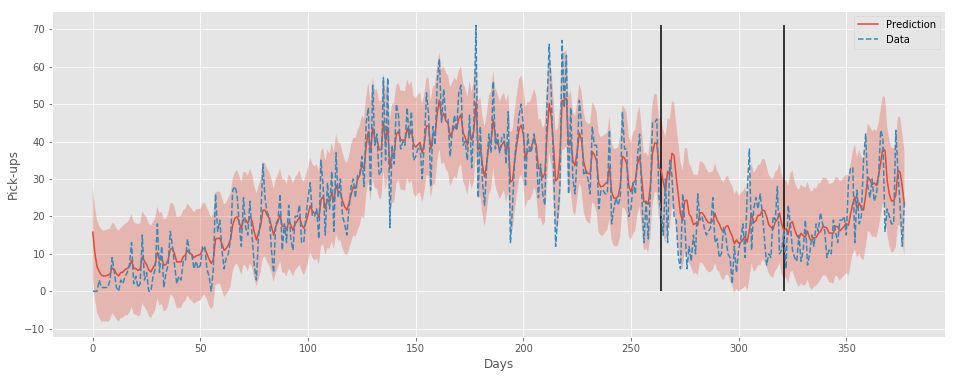

Epoch: 841, Loss: 1.112, Val Loss: 0.954, sigma: 0.351
Epoch: 842, Loss: 1.181, Val Loss: 1.046, sigma: 0.351
Epoch: 843, Loss: 1.165, Val Loss: 1.016, sigma: 0.351
Epoch: 844, Loss: 1.098, Val Loss: 1.206, sigma: 0.351
Epoch: 845, Loss: 1.169, Val Loss: 1.087, sigma: 0.351
Epoch: 846, Loss: 1.115, Val Loss: 1.273, sigma: 0.351
Epoch: 847, Loss: 1.137, Val Loss: 0.947, sigma: 0.351
Epoch: 848, Loss: 1.134, Val Loss: 1.126, sigma: 0.351
Epoch: 849, Loss: 1.137, Val Loss: 1.083, sigma: 0.351
Epoch: 850, Loss: 1.163, Val Loss: 1.026, sigma: 0.351
Epoch: 851, Loss: 1.139, Val Loss: 0.977, sigma: 0.351
Epoch: 852, Loss: 1.117, Val Loss: 0.974, sigma: 0.351
Epoch: 853, Loss: 1.218, Val Loss: 1.094, sigma: 0.351
Epoch: 854, Loss: 1.142, Val Loss: 1.088, sigma: 0.351
Epoch: 855, Loss: 1.090, Val Loss: 0.952, sigma: 0.351
Epoch: 856, Loss: 1.189, Val Loss: 0.986, sigma: 0.351
Epoch: 857, Loss: 1.137, Val Loss: 0.867, sigma: 0.351
Epoch: 858, Loss: 1.171, Val Loss: 0.917, sigma: 0.351
Epoch: 859

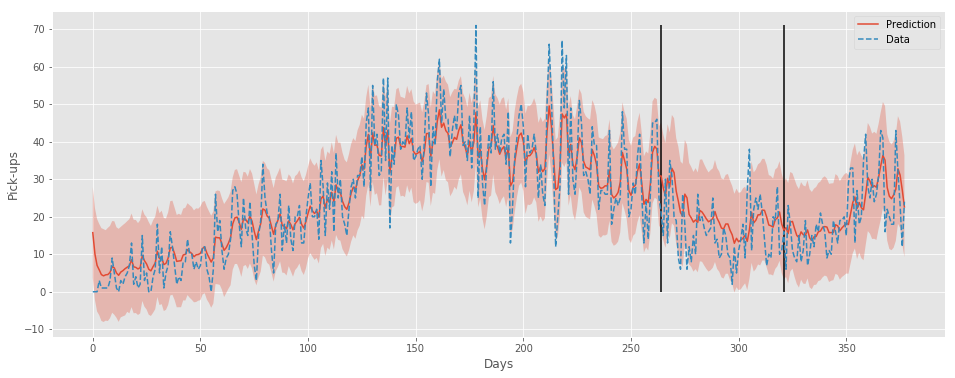

Epoch: 861, Loss: 1.187, Val Loss: 0.927, sigma: 0.351
Epoch: 862, Loss: 1.075, Val Loss: 1.122, sigma: 0.351
Epoch: 863, Loss: 1.179, Val Loss: 0.882, sigma: 0.351
Epoch: 864, Loss: 1.138, Val Loss: 1.169, sigma: 0.351
Epoch: 865, Loss: 1.140, Val Loss: 0.935, sigma: 0.351
Epoch: 866, Loss: 1.095, Val Loss: 0.982, sigma: 0.351
Epoch: 867, Loss: 1.181, Val Loss: 0.878, sigma: 0.351
Epoch: 868, Loss: 1.096, Val Loss: 1.203, sigma: 0.351
Epoch: 869, Loss: 1.118, Val Loss: 1.118, sigma: 0.351
Epoch: 870, Loss: 1.133, Val Loss: 1.104, sigma: 0.351
Epoch: 871, Loss: 1.192, Val Loss: 0.813, sigma: 0.351
Epoch: 872, Loss: 1.134, Val Loss: 1.045, sigma: 0.351
Epoch: 873, Loss: 1.085, Val Loss: 0.877, sigma: 0.351
Epoch: 874, Loss: 1.125, Val Loss: 0.950, sigma: 0.351
Epoch: 875, Loss: 1.156, Val Loss: 1.058, sigma: 0.351
Epoch: 876, Loss: 1.199, Val Loss: 0.971, sigma: 0.351
Epoch: 877, Loss: 1.099, Val Loss: 1.008, sigma: 0.351
Epoch: 878, Loss: 1.139, Val Loss: 0.794, sigma: 0.351
Epoch: 879

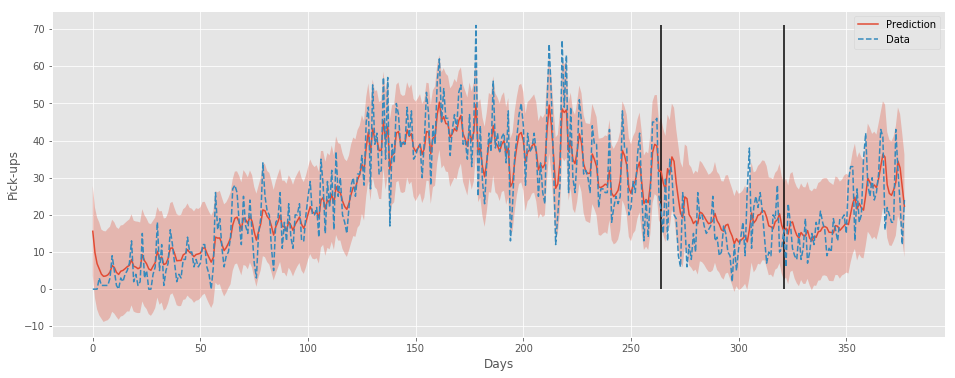

Epoch: 881, Loss: 1.146, Val Loss: 1.104, sigma: 0.351
Epoch: 882, Loss: 1.102, Val Loss: 1.093, sigma: 0.351
Epoch: 883, Loss: 1.161, Val Loss: 1.065, sigma: 0.351
Epoch: 884, Loss: 1.230, Val Loss: 1.008, sigma: 0.351
Epoch: 885, Loss: 1.154, Val Loss: 1.036, sigma: 0.351
Epoch: 886, Loss: 1.157, Val Loss: 1.073, sigma: 0.351
Epoch: 887, Loss: 1.140, Val Loss: 1.121, sigma: 0.351
Epoch: 888, Loss: 1.138, Val Loss: 1.058, sigma: 0.351
Epoch: 889, Loss: 1.203, Val Loss: 0.998, sigma: 0.351
Epoch: 890, Loss: 1.078, Val Loss: 1.065, sigma: 0.351
Epoch: 891, Loss: 1.121, Val Loss: 1.037, sigma: 0.351
Epoch: 892, Loss: 1.166, Val Loss: 1.017, sigma: 0.351
Epoch: 893, Loss: 1.097, Val Loss: 0.938, sigma: 0.351
Epoch: 894, Loss: 1.159, Val Loss: 1.183, sigma: 0.351
Epoch: 895, Loss: 1.162, Val Loss: 1.146, sigma: 0.351
Epoch: 896, Loss: 1.165, Val Loss: 1.013, sigma: 0.351
Epoch: 897, Loss: 1.178, Val Loss: 1.044, sigma: 0.351
Epoch: 898, Loss: 1.153, Val Loss: 1.004, sigma: 0.351
Epoch: 899

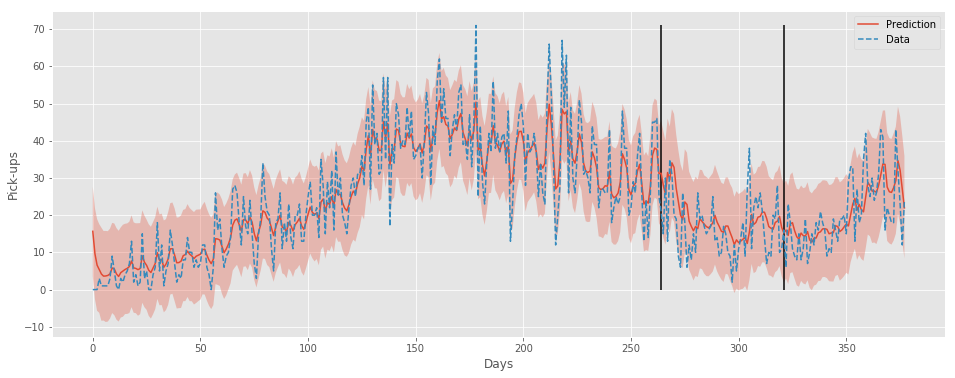

Epoch: 901, Loss: 1.111, Val Loss: 0.921, sigma: 0.351
Epoch: 902, Loss: 1.192, Val Loss: 0.975, sigma: 0.351
Epoch: 903, Loss: 1.168, Val Loss: 0.994, sigma: 0.351
Epoch: 904, Loss: 1.087, Val Loss: 1.153, sigma: 0.351
Epoch: 905, Loss: 1.146, Val Loss: 0.923, sigma: 0.351
Epoch: 906, Loss: 1.158, Val Loss: 1.086, sigma: 0.351
Epoch: 907, Loss: 1.117, Val Loss: 1.108, sigma: 0.351
Epoch: 908, Loss: 1.170, Val Loss: 1.166, sigma: 0.351
Epoch: 909, Loss: 1.146, Val Loss: 1.029, sigma: 0.351
Epoch: 910, Loss: 1.110, Val Loss: 0.972, sigma: 0.351
Epoch: 911, Loss: 1.137, Val Loss: 0.913, sigma: 0.351
Epoch: 912, Loss: 1.121, Val Loss: 1.001, sigma: 0.351
Epoch: 913, Loss: 1.123, Val Loss: 0.959, sigma: 0.351
Epoch: 914, Loss: 1.188, Val Loss: 1.091, sigma: 0.351
Epoch: 915, Loss: 1.036, Val Loss: 1.073, sigma: 0.351
Epoch: 916, Loss: 1.146, Val Loss: 1.136, sigma: 0.351
Epoch: 917, Loss: 1.188, Val Loss: 1.003, sigma: 0.351
Epoch: 918, Loss: 1.190, Val Loss: 1.061, sigma: 0.351
Epoch: 919

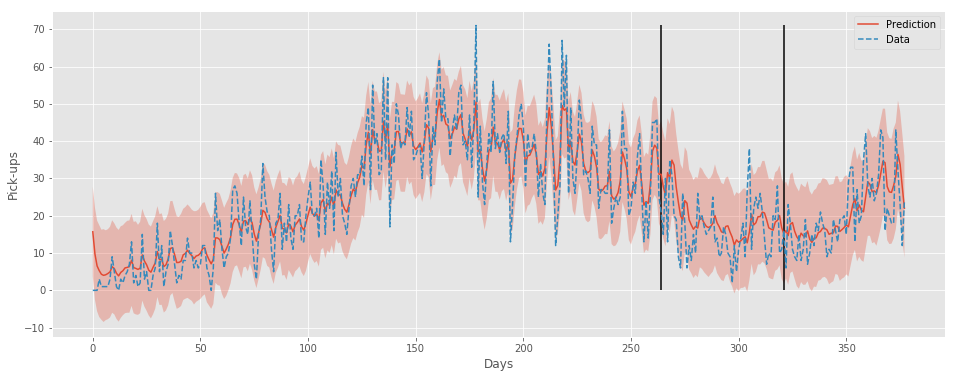

Epoch: 921, Loss: 1.135, Val Loss: 0.903, sigma: 0.351
Epoch: 922, Loss: 1.100, Val Loss: 0.865, sigma: 0.351
Epoch: 923, Loss: 1.157, Val Loss: 0.875, sigma: 0.351
Epoch: 924, Loss: 1.095, Val Loss: 0.999, sigma: 0.351
Epoch: 925, Loss: 1.147, Val Loss: 1.099, sigma: 0.351
Epoch: 926, Loss: 1.117, Val Loss: 1.057, sigma: 0.351
Epoch: 927, Loss: 1.219, Val Loss: 0.977, sigma: 0.351
Epoch: 928, Loss: 1.081, Val Loss: 0.871, sigma: 0.351
Epoch: 929, Loss: 1.173, Val Loss: 1.102, sigma: 0.351
Epoch: 930, Loss: 1.119, Val Loss: 0.988, sigma: 0.351
Epoch: 931, Loss: 1.096, Val Loss: 1.087, sigma: 0.351
Epoch: 932, Loss: 1.117, Val Loss: 0.914, sigma: 0.351
Epoch: 933, Loss: 1.137, Val Loss: 1.054, sigma: 0.351
Epoch: 934, Loss: 1.139, Val Loss: 0.926, sigma: 0.351
Epoch: 935, Loss: 1.156, Val Loss: 1.041, sigma: 0.351
Epoch: 936, Loss: 1.121, Val Loss: 1.045, sigma: 0.351
Epoch: 937, Loss: 1.165, Val Loss: 0.918, sigma: 0.351
Epoch: 938, Loss: 1.146, Val Loss: 1.030, sigma: 0.351
Epoch: 939

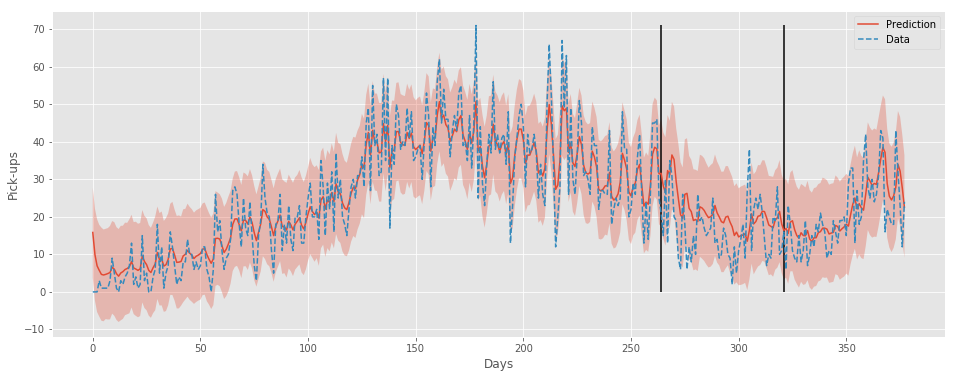

Epoch: 941, Loss: 1.030, Val Loss: 1.135, sigma: 0.351
Epoch: 942, Loss: 1.042, Val Loss: 0.976, sigma: 0.351
Epoch: 943, Loss: 1.116, Val Loss: 0.977, sigma: 0.351
Epoch: 944, Loss: 1.144, Val Loss: 1.008, sigma: 0.351
Epoch: 945, Loss: 1.123, Val Loss: 1.124, sigma: 0.351
Epoch: 946, Loss: 1.155, Val Loss: 1.014, sigma: 0.351
Epoch: 947, Loss: 1.080, Val Loss: 1.110, sigma: 0.351
Epoch: 948, Loss: 1.168, Val Loss: 1.077, sigma: 0.351
Epoch: 949, Loss: 1.161, Val Loss: 0.971, sigma: 0.351
Epoch: 950, Loss: 1.186, Val Loss: 1.002, sigma: 0.351
Epoch: 951, Loss: 1.163, Val Loss: 1.010, sigma: 0.351
Epoch: 952, Loss: 1.194, Val Loss: 0.982, sigma: 0.351
Epoch: 953, Loss: 1.152, Val Loss: 1.250, sigma: 0.351
Epoch: 954, Loss: 1.165, Val Loss: 1.161, sigma: 0.351
Epoch: 955, Loss: 1.197, Val Loss: 1.079, sigma: 0.351
Epoch: 956, Loss: 1.112, Val Loss: 1.046, sigma: 0.351
Epoch: 957, Loss: 1.239, Val Loss: 0.998, sigma: 0.351
Epoch: 958, Loss: 1.181, Val Loss: 1.119, sigma: 0.351
Epoch: 959

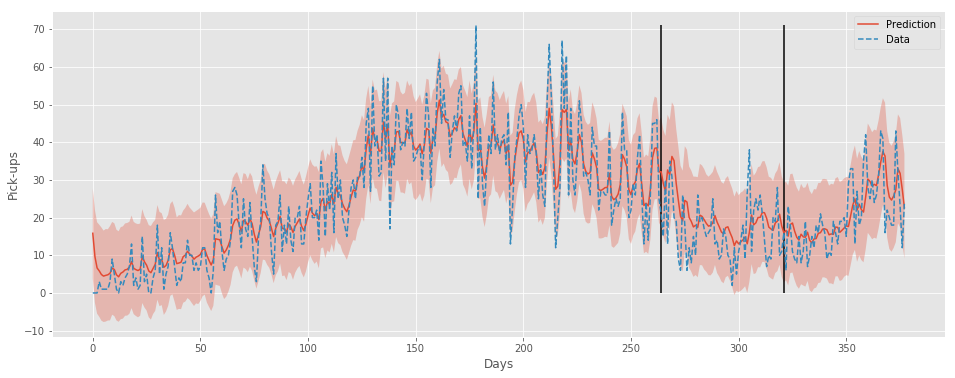

Epoch: 961, Loss: 1.162, Val Loss: 0.980, sigma: 0.351
Epoch: 962, Loss: 1.135, Val Loss: 1.086, sigma: 0.351
Epoch: 963, Loss: 1.146, Val Loss: 1.054, sigma: 0.351
Epoch: 964, Loss: 1.186, Val Loss: 0.986, sigma: 0.351
Epoch: 965, Loss: 1.178, Val Loss: 1.192, sigma: 0.351
Epoch: 966, Loss: 1.159, Val Loss: 1.151, sigma: 0.351
Epoch: 967, Loss: 1.101, Val Loss: 0.810, sigma: 0.351
Epoch: 968, Loss: 1.143, Val Loss: 0.974, sigma: 0.351
Epoch: 969, Loss: 1.095, Val Loss: 1.238, sigma: 0.351
Epoch: 970, Loss: 1.136, Val Loss: 0.945, sigma: 0.351
Epoch: 971, Loss: 1.082, Val Loss: 1.302, sigma: 0.351
Epoch: 972, Loss: 1.083, Val Loss: 1.012, sigma: 0.351
Epoch: 973, Loss: 1.133, Val Loss: 1.077, sigma: 0.351
Epoch: 974, Loss: 1.196, Val Loss: 1.090, sigma: 0.351
Epoch: 975, Loss: 1.192, Val Loss: 1.147, sigma: 0.351
Epoch: 976, Loss: 1.121, Val Loss: 1.118, sigma: 0.351
Epoch: 977, Loss: 1.167, Val Loss: 1.133, sigma: 0.351
Epoch: 978, Loss: 1.118, Val Loss: 1.010, sigma: 0.351
Epoch: 979

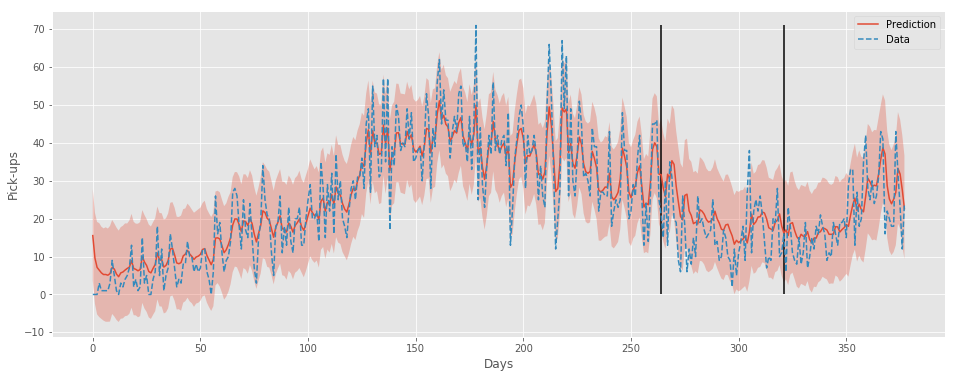

Epoch: 981, Loss: 1.206, Val Loss: 1.057, sigma: 0.351
Epoch: 982, Loss: 1.186, Val Loss: 1.075, sigma: 0.351
Epoch: 983, Loss: 1.117, Val Loss: 1.051, sigma: 0.351
Epoch: 984, Loss: 1.102, Val Loss: 1.058, sigma: 0.351
Epoch: 985, Loss: 1.177, Val Loss: 0.925, sigma: 0.351
Epoch: 986, Loss: 1.195, Val Loss: 0.968, sigma: 0.351
Epoch: 987, Loss: 1.164, Val Loss: 0.974, sigma: 0.351
Epoch: 988, Loss: 1.188, Val Loss: 0.908, sigma: 0.351
Epoch: 989, Loss: 1.181, Val Loss: 0.989, sigma: 0.351
Epoch: 990, Loss: 1.150, Val Loss: 1.028, sigma: 0.351
Epoch: 991, Loss: 1.133, Val Loss: 1.222, sigma: 0.351
Epoch: 992, Loss: 1.240, Val Loss: 1.012, sigma: 0.351
Epoch: 993, Loss: 1.145, Val Loss: 0.959, sigma: 0.351
Epoch: 994, Loss: 1.149, Val Loss: 0.856, sigma: 0.351
Epoch: 995, Loss: 1.017, Val Loss: 1.277, sigma: 0.351
Epoch: 996, Loss: 1.070, Val Loss: 0.917, sigma: 0.351
Epoch: 997, Loss: 1.153, Val Loss: 1.102, sigma: 0.351
Epoch: 998, Loss: 1.164, Val Loss: 0.926, sigma: 0.351
Epoch: 999

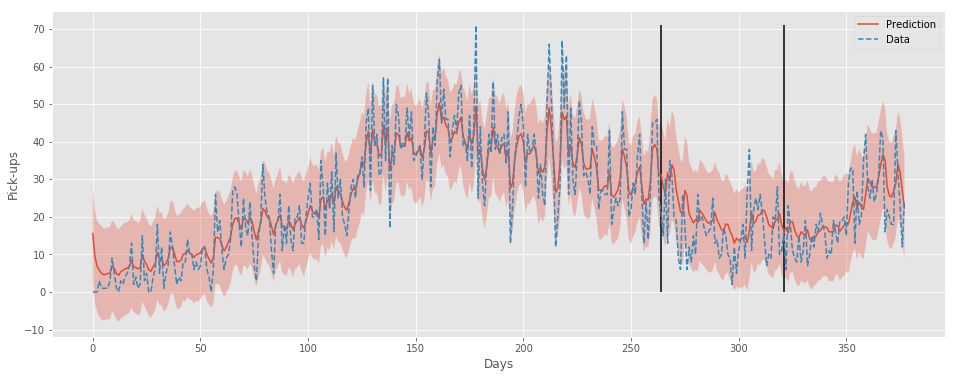

In [159]:
torch.manual_seed(10)
optimizer_ = torch.optim.Adam(list(dkf.trans.parameters()) + list(dkf.emitter.parameters()) + list(dkf.rnn.parameters()) + list(dkf.combiner.parameters()), lr=0.001)
dkf.annealing_factor = .5

loss_fn = Trace_ELBO(num_particles=1).differentiable_loss

num_epochs = 1000
for epoch in range(num_epochs):
    try:
        loss = loss_fn(dkf.model, dkf.guide, y_train_sc.float())
        loss.backward()
        optimizer_1.step()
        optimizer_1.zero_grad()

        val_loss = loss_fn(dkf.model, dkf.guide, y_val_sc) / y_val_sc.size(1)
        print("Epoch: {0}, Loss: {1:.3f}, Val Loss: {2:.3f}, sigma: {3:.3f}".format(epoch+1, loss/y_train_sc.size(1), val_loss, dkf.sigma.item()))
            
        if epoch % 20 == 19:
            # define initial hidden state
            h_0_contig = dkf.h_0.expand(1, 1, dkf.rnn.hidden_size).contiguous()

            # define num_latent samples
            num_latent_samples = 10000

            # Expand z_prev to have dimensions (num_latent_samples, latent_size)
            z_prev = dkf.z_0.expand(num_latent_samples, dkf.z_0.size(0))

            # book-keeping
            z_samples = []
            z_scales = [[], []]
            y_samples = []
            y_mean = []
            y_025 = []
            y_975 = []

            # Train Predictions
            rnn_output, rnn_hidden_state = dkf.rnn(y_sc[:, :T, :].float(), h_0_contig)

            rnn_output = rnn_output.expand(num_latent_samples, rnn_output.size(1), rnn_output.size(2))

            for t in range(T):
                # compute mean and variance of z_t
                z_loc, z_scale = dkf.combiner(z_prev, rnn_output[:, t, :])
                z_scales[0].append(z_scale.norm(dim=1).mean().item())
                z_scales[1].append(z_scale.norm(dim=1).std().item())
                # sample from z_t distribution
                z_t = dist.Normal(loc=z_loc, scale=z_scale).to_event(1).sample(sample_shape=[1]).reshape(z_prev.shape)
                if t != T-1:
                    z_samples.append(z_t)

                # compute mean of y_t
                y_loc = dkf.emitter(z_t).view(num_latent_samples, y_sc.size(2))

                # sample from y_t distribution
                y_t = dist.Normal(loc=y_loc, scale=dkf.sigma).to_event(1).sample(sample_shape=[1]).view(num_latent_samples, y_sc.size(2)).detach().numpy()
                y_samples.append(y_t)

                # store z_t for next computation
                if t != T-1:
                    z_prev = z_samples[-1]

                # store predictions and CI
                y_mean.append(np.mean(y_t, axis=0))
                y_025.append(np.quantile(a=y_t, q=0.025, axis=0))
                y_975.append(np.quantile(a=y_t, q=0.975, axis=0))

            # Test Predictions
            for t in range(T, T + T_pred):
                rnn_output, rnn_hidden_state = dkf.rnn(y_sc[:, :t, :].float(), h_0_contig)

                # reverse rnn_output to get initial ordering
            #                 rnn_output = torch.flip(rnn_output[:, :, :], dims=[1])

                rnn_output = rnn_output.expand(num_latent_samples, rnn_output.size(1), rnn_output.size(2))

                # compute mean and variance of z_t_1
                z_loc, z_scale = dkf.combiner(z_samples[-1], rnn_output[:, -1, :])

                # sample from z_t_1 distribution
                z_t_1 = dist.Normal(loc=z_loc, scale=z_scale).to_event(1).sample(sample_shape=[1]).reshape(z_prev.shape)
                z_samples.append(z_t_1)

                # run transition network forward
                z_t_loc, z_t_scale = dkf.trans(z_t_1)
                z_scales[0].append(z_t_scale.norm(dim=1).mean().item())
                z_scales[1].append(z_t_scale.norm(dim=1).std().item())
                z_t = dist.Normal(loc=z_t_loc, scale=z_t_scale).to_event(1).sample(sample_shape=[1]).reshape(z_prev.shape)

                # compute mean of y_t
                y_loc = dkf.emitter(z_t).view(num_latent_samples, y_sc.size(2))

                # sample from y_t distribution
                y_t = dist.Normal(loc=y_loc, scale=dkf.sigma).to_event(1).sample(sample_shape=[1]).view(num_latent_samples, y_sc.size(2)).detach().numpy()
                y_samples.append(y_t)

                # store predictions and CI
                y_mean.append(np.mean(y_t, axis=0))
                y_025.append(np.quantile(a=y_t, q=0.025, axis=0))
                y_975.append(np.quantile(a=y_t, q=0.975, axis=0))

            # compute predictions
            y_pred = scaler.inverse_transform(np.array(y_mean))
            y_025 = scaler.inverse_transform(np.array(y_025))
            y_975 = scaler.inverse_transform(np.array(y_975))



            for hub in range(y_sc.shape[2]):
                print("\n SUPER-HUB ", hub+1)
                print("\n==== Train Results ====")
                print("R2: {0:.3f}, MAE: {1:.3f}, RMSE: {2:.3f}".format(r2_score(y_train[:, hub].reshape(-1,1), y_pred[:T, hub]), 
                                                                       mean_absolute_error(y_train[ :, hub].reshape(-1,1), y_pred[:T, hub]), 
                                                                       np.sqrt(mean_squared_error(y_train[:, hub].reshape(-1,1), y_pred[:T, hub]))))
                print("==== Validation Results ====")
                print("R2: {0:.3f}, MAE: {1:.3f}, RMSE: {2:.3f}".format(r2_score(y_val[:, hub].reshape(-1,1), y_pred[T:T+T_val, hub]), 
                                                                       mean_absolute_error(y_val[:, hub].reshape(-1,1), y_pred[T:T+T_val, hub]), 
                                                                       np.sqrt(mean_squared_error(y_val[:, hub].reshape(-1,1), y_pred[T:T+T_val, hub]))))
                print("==== Test Results ====")
                print("R2: {0:.3f}, MAE: {1:.3f}, RMSE: {2:.3f}".format(r2_score(y_test[:, hub].reshape(-1,1), y_pred[T+T_val:T+T_val+T_test, hub]), 
                                                                       mean_absolute_error(y_test[:, hub].reshape(-1,1), y_pred[T+T_val:T+T_val+T_test, hub]), 
                                                                       np.sqrt(mean_squared_error(y_test[:, hub].reshape(-1,1), y_pred[T+T_val:T+T_val+T_test, hub]))))
                
                plt.figure(figsize=(16, 6))
                plt.plot(y_pred[:,hub], label="Prediction")
                plt.fill_between(np.arange(len(y_025[:,hub])), y_025[:,hub], y_975[:,hub], alpha=0.3)
                plt.vlines(T, ymin=y.min(),ymax=y.max())
                plt.vlines(T+T_val, ymin=y.min(),ymax=y.max())
                plt.plot(np.arange(T+T_pred), y.flatten(), label="Data", linestyle="--")
                plt.xlabel("Days")
                plt.ylabel("Pick-ups")
                plt.legend()
                plt.show()
    except KeyboardInterrupt:
        break